# 'Data Science 4 Covid19': analysis of testing dataset

### UC Sistemas Inteligentes para a Bioinformática 20 | 21

Group 4: 
> Carina Afonso PG40952 <br>
> Laura Duro PG40959 <br>
> Miguel Rocha PG40967 <br> 
> Miguel Martins PG40969 <br>

## 1. Work contextualization and data description

The Covid19 pandemic has been widely studied across several fields due to its large-scale effects globally. More than 1.5 million people have died due to health complications caused by SARS-CoV-2 infection, since the final months of 2019. 

To fight this pandemic countries have been deploying different approaches, namely testing policies. In this effort, we propose to analyse and explore the official testing data available for different countries. We aim to relate this information (tests wise) with other variables (demographic descriptors and pandemic related information) trough computational methods such as machine and deep learning.

The data chosen for this work was retrieved from 'Our World in Data': https://ourworldindata.org/coronavirus-testing [1]. It comprises of a time series, updated around twice a week, with mostly numeric data from official sources from 111 countries, from which we aim to predict events or future tendencies.

## 2. Data pre-processing

### 2.1. Imports

#### 2.1.1. Libraries required

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math

#Visualization
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns

#PCA
from sklearn.decomposition import PCA 

#Hierarchical clustering
import scipy.cluster.hierarchy as hac
from scipy.cluster.hierarchy import fcluster


#ML
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
import sklearn.metrics as metrics_ml
from sklearn.metrics import make_scorer, r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import ADFTest, auto_arima


#Deep Learning
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout

#### 2.1.2. Data import

In [2]:
#import dataset - covid-19 testing data
data_imported = pd.read_csv('owid-covid-data.csv')

### 2.2. Initial data screening

In [3]:
print('Shape:\t', data_imported.shape, '\n')
print('Columns:', data_imported.columns.values, '\n')

Shape:	 (60121, 55) 

Columns: ['iso_code' 'continent' 'location' 'date' 'total_cases' 'new_cases'
 'new_cases_smoothed' 'total_deaths' 'new_deaths' 'new_deaths_smoothed'
 'total_cases_per_million' 'new_cases_per_million'
 'new_cases_smoothed_per_million' 'total_deaths_per_million'
 'new_deaths_per_million' 'new_deaths_smoothed_per_million'
 'reproduction_rate' 'icu_patients' 'icu_patients_per_million'
 'hosp_patients' 'hosp_patients_per_million' 'weekly_icu_admissions'
 'weekly_icu_admissions_per_million' 'weekly_hosp_admissions'
 'weekly_hosp_admissions_per_million' 'new_tests' 'total_tests'
 'total_tests_per_thousand' 'new_tests_per_thousand' 'new_tests_smoothed'
 'new_tests_smoothed_per_thousand' 'positive_rate' 'tests_per_case'
 'tests_units' 'total_vaccinations' 'new_vaccinations'
 'new_vaccinations_smoothed' 'total_vaccinations_per_hundred'
 'new_vaccinations_smoothed_per_million' 'stringency_index' 'population'
 'population_density' 'median_age' 'aged_65_older' 'aged_70_older'


Trough the analysis of the presented variables in the dataset, we decided to remove the ones that presented no interest to the proposed task (testing analysis).

In [4]:
#drop columns with no interest
data_imported.columns
data_imported = data_imported.drop(columns = ['cardiovasc_death_rate', 
                                              'diabetes_prevalence', 
                                              'female_smokers',
                                              'male_smokers',
                                              'total_vaccinations',
                                              'total_vaccinations_per_hundred',
                                              'new_vaccinations',
                                              'new_vaccinations_smoothed', 
                                              'total_vaccinations_per_hundred',
                                              'new_vaccinations_smoothed_per_million'])

print('Shape:\t', data_imported.shape, '\n')

Shape:	 (60121, 46) 



In [5]:
#type of data per variable of interest
data_imported.dtypes

iso_code                               object
continent                              object
location                               object
date                                   object
total_cases                           float64
new_cases                             float64
new_cases_smoothed                    float64
total_deaths                          float64
new_deaths                            float64
new_deaths_smoothed                   float64
total_cases_per_million               float64
new_cases_per_million                 float64
new_cases_smoothed_per_million        float64
total_deaths_per_million              float64
new_deaths_per_million                float64
new_deaths_smoothed_per_million       float64
reproduction_rate                     float64
icu_patients                          float64
icu_patients_per_million              float64
hosp_patients                         float64
hosp_patients_per_million             float64
weekly_icu_admissions             

#### 2.2.1. Tests_units (variable)

Different countries might have different methods of registering data and/or reported their data in different formats.

In [6]:
#see test units
print('Number of entries per test type:')
print(data_imported.groupby(['tests_units']).size(), '\n\n')

#frequency table per countries
freq_table = pd.crosstab(index = data_imported['tests_units'], columns = data_imported['iso_code'])
print('Entries distribution per countries:\n')
print(freq_table, '\n\n')
print('Number of countries per test type:')
print((freq_table/freq_table).sum(axis = 1), '\n')
print('Total of countries:', ((freq_table/freq_table).sum(axis = 1)).sum(), '\n\n')

#check for missing values
null = data_imported.iloc[:, 33].isnull().sum()
na = data_imported.iloc[:, 33].isna().sum()
print('Missing values')
print('Null:', null, '\tNaN:', na, '\n')

Number of entries per test type:
tests_units
people tested       6947
samples tested      5294
tests performed    19539
units unclear        666
dtype: int64 


Entries distribution per countries:

iso_code         ARE  ARG  AUS  AUT  BEL  BGD  BGR  BHR  BIH  BLR  ...  TUR  \
tests_units                                                        ...        
people tested      0  373    0    0    0    0    0    0    0    0  ...    0   
samples tested     0    0    0    0    0    0    0    0    0    0  ...    0   
tests performed  351    0  297  286  317  316  278    0  275  266  ...  292   
units unclear      0    0    0    0    0    0    0  315    0    0  ...    0   

iso_code         TWN  UGA  UKR  URY  USA  VNM  ZAF  ZMB  ZWE  
tests_units                                                   
people tested    363    0    0    0    0    0  341    0    0  
samples tested     0  207    0    0    0  157    0    0    0  
tests performed    0    0  279  291  315    0    0  301  248  
units unclea

After seeing how countries are distributed based on the tests_units variable we decided to use only data from dataset entries which reported the number of tests and not the number of people tested. We also decided to discard dataset entries without defined units.

We also checked for missing values (which in this case correspond to null values).

Since the data was also registered at an International and Worldwide level in this dataset, we decided to discard these entries as they comprehend a compilation of data from several countries.

In [7]:
#drop Nan
data_imported = data_imported.dropna(subset = ['tests_units'])

print('Missing values')
na = data_imported.iloc[:, 33].isna().sum()
print('NaN:', na, '\n\n')


#drop countries with odd units
countries_discard = pd.concat(objs = (freq_table.loc['units unclear'][freq_table.loc['units unclear'][:] != 0], 
                                      freq_table.loc['people tested'][freq_table.loc['people tested'][:] != 0]))
countries_discard.keys()

#discard international data
index_discard = np.concatenate([data_imported['location'][data_imported['location'] == 'International'].keys().values,
                                data_imported['location'][data_imported['location'] == 'World'].keys().values])
#discard countries without standardized testing
for code in countries_discard.keys().values:
    index_discard = np.concatenate([index_discard,
                                    data_imported['iso_code'][data_imported['iso_code'] == code].keys().values])

screened_data = data_imported.drop(index = index_discard)
    
#frequency table per countries
freq_table = pd.crosstab(index = screened_data['tests_units'], columns = screened_data['iso_code'])
print('Number of countries per test type:')
print((freq_table/freq_table).sum(axis = 1), '\n')
print('Total of countries:', ((freq_table/freq_table).sum(axis = 1)).sum(), '\n\n')

Missing values
NaN: 0 


Number of countries per test type:
tests_units
samples tested     19.0
tests performed    70.0
dtype: float64 

Total of countries: 89.0 




In total, 89 countries reported testing data in a similar way and further analysis will be conducted for these countries (we will be considering the number of tests performed / samples tested, not the number of people tested).

#### 2.2.2. Other testing variables

In [8]:
#NaN 
#screened_data['total_cases']

print('Null:')
null = screened_data.iloc[:, 4:31].isnull().sum()
print(null, '\n')
print('Total:\t', null.sum(), '\n\n')
print('NaN:')
na = screened_data.iloc[:, 4:31].isna().sum()
print(na, '\n')
print('Total:\t', na.sum(), '\n\n')

screened_data[['new_cases', 'new_cases_smoothed', 'new_deaths', 'new_deaths_smoothed', 'new_cases_per_million', 
'new_cases_smoothed_per_million', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'icu_patients', 
'icu_patients_per_million', 'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 
'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 
'new_tests_per_thousand', 'new_tests_smoothed', 'new_tests_smoothed_per_thousand']] = screened_data[['new_cases', 
'new_cases_smoothed', 'new_deaths', 'new_deaths_smoothed', 'new_cases_per_million', 'new_cases_smoothed_per_million', 
'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'icu_patients', 'icu_patients_per_million', 
'hosp_patients', 'hosp_patients_per_million', 'weekly_icu_admissions', 'weekly_icu_admissions_per_million', 
'weekly_hosp_admissions', 'weekly_hosp_admissions_per_million', 'new_tests', 'new_tests_per_thousand', 
'new_tests_smoothed', 'new_tests_smoothed_per_thousand']].fillna(0)

print('NaN:')
na = screened_data.iloc[:, 4:31].isna().sum()
print(na, '\n')
print('Total:\t', na.sum(), '\n\n')

Null:
total_cases                             347
new_cases                               349
new_cases_smoothed                      495
total_deaths                           1639
new_deaths                             1639
new_deaths_smoothed                     495
total_cases_per_million                 347
new_cases_per_million                   349
new_cases_smoothed_per_million          495
total_deaths_per_million               1639
new_deaths_per_million                 1639
new_deaths_smoothed_per_million         495
reproduction_rate                      2830
icu_patients                          19949
icu_patients_per_million              19949
hosp_patients                         19817
hosp_patients_per_million             19817
weekly_icu_admissions                 24431
weekly_icu_admissions_per_million     24431
weekly_hosp_admissions                24136
weekly_hosp_admissions_per_million    24136
new_tests                              3877
total_tests               

Substitution of missing values of these pandemic related variables with 0 (when reported as a missing value, in these variables, it means there was no information on that entry regarding that variable).

In [9]:
print('NaN:')
na = screened_data.iloc[:, 4:].isna().sum()
print(na, '\n')
print('Total:\t', na.sum(), '\n\n')

NaN:
total_cases                             347
new_cases                                 0
new_cases_smoothed                        0
total_deaths                           1639
new_deaths                                0
new_deaths_smoothed                       0
total_cases_per_million                 347
new_cases_per_million                     0
new_cases_smoothed_per_million            0
total_deaths_per_million               1639
new_deaths_per_million                    0
new_deaths_smoothed_per_million           0
reproduction_rate                      2830
icu_patients                              0
icu_patients_per_million                  0
hosp_patients                             0
hosp_patients_per_million                 0
weekly_icu_admissions                     0
weekly_icu_admissions_per_million         0
weekly_hosp_admissions                    0
weekly_hosp_admissions_per_million        0
new_tests                                 0
total_tests                

In [10]:
print('Shape:\n', screened_data.shape, '\n')

screened_data = screened_data.drop(columns = ['handwashing_facilities'])
screened_data = screened_data.dropna(axis = 0)

print('NaN:')
na = screened_data.iloc[:, 4:].isna().sum()
print(na, '\n')
print('Total:\t', na.sum(), '\n\n')

print('Shape:\n', screened_data.shape)

Shape:
 (24833, 46) 

NaN:
total_cases                           0
new_cases                             0
new_cases_smoothed                    0
total_deaths                          0
new_deaths                            0
new_deaths_smoothed                   0
total_cases_per_million               0
new_cases_per_million                 0
new_cases_smoothed_per_million        0
total_deaths_per_million              0
new_deaths_per_million                0
new_deaths_smoothed_per_million       0
reproduction_rate                     0
icu_patients                          0
icu_patients_per_million              0
hosp_patients                         0
hosp_patients_per_million             0
weekly_icu_admissions                 0
weekly_icu_admissions_per_million     0
weekly_hosp_admissions                0
weekly_hosp_admissions_per_million    0
new_tests                             0
total_tests                           0
total_tests_per_thousand              0
new_tests_per

The 'total...' type of variables missing values could not be substituted with zero and therefore we decided to drop the corresponding entries.

The drop of the column 'handwashing_facilities' was due to lack of information regarding a considerable amount of countries (over 14 000 entries).

To deal with the other missing values, instead of dropping the columns in question we decided to drop the entries. In these cases, we could not replace missing values with 0 because these variables do not represent counts but demographic indicators with their own scale and values associated.

In [11]:
 screened_data['iso_code'].unique().size

57

Further filtering of the data reduced the number of countries to a total of 57.

### 2.3. Statistical Analysis



In [12]:
screened_data.describe()

,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,total_cases_per_million,new_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,...,population,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
count,1.340900e+04,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,...,1.340900e+04,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000,13409.000000
mean,2.367153e+05,2549.834290,2496.031418,6365.440898,52.633455,52.023883,6115.155333,76.832690,74.921979,163.711765,...,6.234894e+07,170.613543,33.981759,11.697703,7.638035,22423.816502,7.416705,3.204193,75.426317,0.765121
std,9.129812e+05,9104.706548,8867.637117,18011.375927,154.230454,145.232081,9539.682389,156.796382,138.348083,255.602728,...,1.973787e+08,263.240817,8.902450,6.392287,4.506795,18484.053052,15.257563,2.265572,6.104895,0.132696
min,1.010000e+02,-161.000000,0.143000,1.000000,-117.000000,-117.286000,0.177000,-95.122000,0.006000,0.003000,...,3.412500e+05,3.202000,16.400000,2.168000,1.308000,1095.042000,0.100000,0.200000,61.040000,0.463000
25%,3.446000e+03,31.000000,38.714000,64.000000,0.000000,0.571000,424.260000,3.261000,3.750000,8.116000,...,6.486201e+06,42.729000,27.600000,5.989000,3.414000,7292.458000,0.200000,1.400000,72.060000,0.685000
50%,2.401400e+04,309.000000,311.000000,564.000000,5.000000,5.429000,1913.208000,18.434000,18.991000,42.233000,...,1.486293e+07,88.125000,35.400000,11.373000,6.938000,22267.037000,0.700000,2.800000,76.740000,0.798000
75%,1.454730e+05,1511.000000,1495.429000,3553.000000,31.000000,31.571000,7113.868000,80.569000,79.738000,191.111000,...,5.088288e+07,205.859000,42.300000,18.571000,11.976000,30155.152000,4.500000,4.510000,80.900000,0.871000
max,1.904217e+07,227253.000000,216649.286000,332068.000000,4143.000000,2603.857000,74148.210000,3142.293000,1536.030000,1677.450000,...,1.380004e+09,1454.037000,47.900000,23.021000,16.240000,94277.965000,77.600000,8.800000,83.560000,0.939000


Above there are descriptive analysis made for each of the selected variables.

Text(0, 0.5, 'Share of the Population (%)')

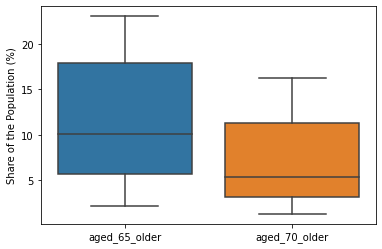

In [13]:
fig, axes = plt.subplots(1, 1, sharex = True)
sns.boxplot(data = screened_data[['iso_code', 'aged_65_older','aged_70_older']].drop_duplicates(subset=['iso_code']))
axes.set_ylabel('Share of the Population (%)')

In the figure above we can see the percentage of the population over 65 years old (yo) and over 70 yo. In some countries, the percentage reaches above 10% of the population which could be of importance considering that people in this age are considered part of the groups at risk.

Text(0, 0.5, 'Age (years)')

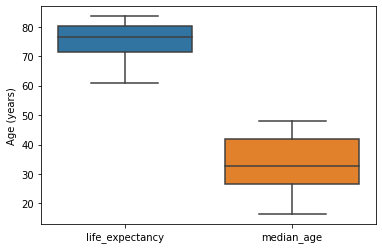

In [14]:
fig, axes = plt.subplots(1, 1, sharex = True)
sns.boxplot(data = screened_data[['iso_code', 'life_expectancy', 'median_age']].drop_duplicates(subset=['iso_code']))
axes.set_ylabel('Age (years)')

Regarding 'life_expectancy', as seen in the figure above, there's an interval between the ages of 70 and 80 which comprises around 50% of the countries' life expectancy values.
The median age for the 57 countries considered shows that possibly all types of countries (under developed, in development and developed) are present - median age is one of the development indicators. [2-3]

Text(0, 0.5, 'HDI')

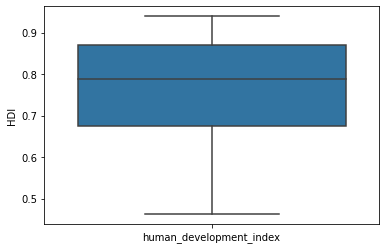

In [15]:
fig, axes = plt.subplots(1, 1, sharex = True)
sns.boxplot(data = screened_data[['iso_code', 'human_development_index']].drop_duplicates(subset=['iso_code']))
axes.set_ylabel('HDI')

According to the 'Human Development Report 2020: Reader's Guide', by United Nations Development Programme, 'HDI classifications are based on HDI fixed cut-off points, which are derived from the quartiles of distributions of the component indicators. The cut-off points are HDI of less than 0.550 for low human development, 0.550–0.699 for medium human development, 0.700–0.799 for high human development and 0.800 or greater for very high human development.'

In the figure above we can perceive that about 25% of the countries considered low to medium human development.

Text(0, 0.5, 'Positive rate')

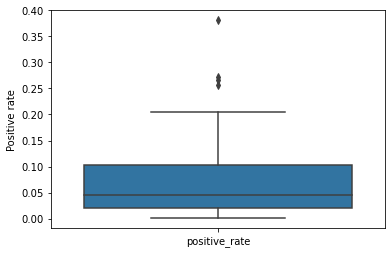

In [16]:
fig, axes = plt.subplots(1, 1, sharex = True)
sns.boxplot(data = screened_data[['iso_code','positive_rate']].drop_duplicates(subset=['iso_code']))
axes.set_ylabel('Positive rate')

The positive rates (ratio between positive tests and tests performed), for 50% of the countries selected, is below 5%. There are some countries who present an alarming value for positive rates.

### 2.4. Time series dataset preparation

Since we are working with time series it is necessary to index the date.

In [17]:
original = screened_data
print('Type of data for date information:')
print(screened_data['date'].dtypes)
screened_data['date'] = pd.to_datetime(screened_data['date']) 
print('\nType of data for date information after conversion:')
print(screened_data['date'].dtypes)
print('\nShape of dataset:')
print(screened_data.shape)
screened_data = screened_data.set_index('date')
print('\nShape of dataset after indexing:')
print(screened_data.shape)

Type of data for date information:
object

Type of data for date information after conversion:
datetime64[ns]

Shape of dataset:
(13409, 45)

Shape of dataset after indexing:
(13409, 44)


#### 2.4.1. Dataset normalization

We aim to construct machine learning and deep learning models and it is beneficial to only use normalized data. We will also be using the normalized dataset for unsupervised machine learning analysis.

In [18]:
screened_data.columns

Index(['iso_code', 'continent', 'location', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'hospi

In [19]:
normalize_data = screened_data[['iso_code', 'continent', 'location', 'total_cases_per_million', 
                                'new_cases_smoothed_per_million', 'total_deaths_per_million', 
                                'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients_per_million', 
                                'hosp_patients_per_million', 'weekly_icu_admissions_per_million', 
                                'weekly_hosp_admissions_per_million', 'total_tests_per_thousand', 
                                'new_tests_smoothed_per_thousand', 'positive_rate', 'tests_per_case', 
                                'stringency_index', 'population_density', 'median_age', 'aged_65_older', 
                                'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'hospital_beds_per_thousand', 
                                'life_expectancy', 'human_development_index']]

##### 2.4.1.1. Differencing the dataset

The de-trending of the data allows for the emergence of the real tendencies of the data. Since we have a time series and some variables will be of incremental values, it is important to avoid identifying such variables as strictly incremental tendencies. Some variables are constant values (i.e. gdp per capita) for which de-trending wouldn't make sense.

In [20]:
normalize_data_diff = pd.DataFrame(columns = ['total_cases_per_million', 'new_cases_smoothed_per_million', 
                                              'total_deaths_per_million', 'new_deaths_smoothed_per_million',
                                              'icu_patients_per_million', 'hosp_patients_per_million', 
                                              'weekly_icu_admissions_per_million', 'weekly_hosp_admissions_per_million',
                                              'total_tests_per_thousand', 'new_tests_smoothed_per_thousand',
                                              'tests_per_case'])

for iso in normalize_data['iso_code'].unique():
    normalize_data[normalize_data['iso_code'] == iso].shape
    normalize_data_diff = pd.concat([normalize_data_diff, 
                                    (normalize_data.loc[normalize_data['iso_code'] == iso][['total_cases_per_million', 
                                                       'new_cases_smoothed_per_million', 'total_deaths_per_million', 
                                                       'new_deaths_smoothed_per_million', 'icu_patients_per_million', 
                                                       'hosp_patients_per_million', 'weekly_icu_admissions_per_million',
                                                       'weekly_hosp_admissions_per_million','total_tests_per_thousand',
                                                       'new_tests_smoothed_per_thousand', 'tests_per_case']].diff())])

normalize_data_diff[['iso_code', 'continent', 'location',
                     'reproduction_rate', 'positive_rate', 
                     'stringency_index', 'population_density', 
                     'median_age', 'aged_65_older', 'aged_70_older', 
                     'gdp_per_capita', 'extreme_poverty', 
                     'hospital_beds_per_thousand', 
                     'life_expectancy', 'human_development_index']] = normalize_data[['iso_code', 'continent', 
                                                                                      'location',
                                                                                      'reproduction_rate', 
                                                                                      'positive_rate', 
                                                                                      'stringency_index', 
                                                                                      'population_density', 
                                                                                      'median_age', 'aged_65_older', 
                                                                                      'aged_70_older', 'gdp_per_capita',
                                                                                      'extreme_poverty', 
                                                                                      'hospital_beds_per_thousand', 
                                                                                      'life_expectancy', 
                                                                                      'human_development_index']]
    

normalize_data_diff = normalize_data_diff.dropna(axis = 0)

## 3. Unsupervised Machine Learning

### 3.1. Principal Component Analysis (PCA) 

#### 3.1.1. Data preparation

In [22]:
pca_data = normalize_data[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million', 
                           'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients_per_million', 
                           'hosp_patients_per_million', 'weekly_icu_admissions_per_million', 
                           'weekly_hosp_admissions_per_million', 'total_tests_per_thousand', 'positive_rate', 
                           'tests_per_case', 'stringency_index', 'population_density', 'median_age', 'aged_65_older', 
                           'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 'hospital_beds_per_thousand', 
                           'life_expectancy', 'human_development_index']]

For this analysis we choose the variables that we thought that could be relevant (i.e. we excluded variables related to the countries original data). 

Since we are analysing testing data, we aim to predict the variable 'new_tests_smoothed_per_thousand'. We choose this variable because its value is representative in a ration fashion (value per thousand), making it comparable between countries, and it has already been cautioned the appearance of sudden spikes as a result of an update of testing data from weekend report.

In [23]:
data_diff_pca = normalize_data_diff

new_tests_diff = data_diff_pca['new_tests_smoothed_per_thousand']

data_diff_pca = data_diff_pca.drop(columns = ['new_tests_smoothed_per_thousand', 'iso_code', 'continent', 'location'])

We also will be performing PCA on the differenciated dataset.

Text(0, 0.5, 'Number of new tests smothed per thousand de-trended')

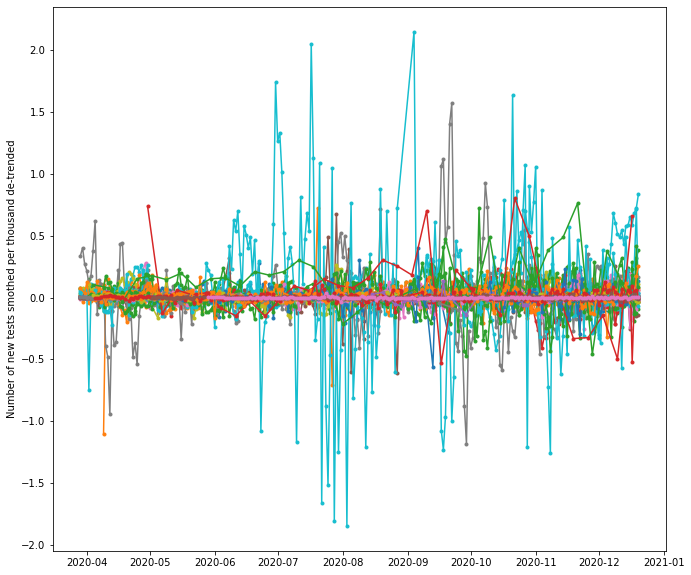

In [24]:
start, end = '2020-03-29', '2020-12-20'

fig, ax = plt.subplots(figsize=(11, 10))
for iso in normalize_data_diff['iso_code'].unique():
    plot_data = normalize_data_diff[normalize_data_diff['iso_code'] == iso]
    ax.plot(plot_data.loc[start:end, 'new_tests_smoothed_per_thousand'], marker='o', markersize = 3, linestyle='-', label='First Order Differencing')
ax.set_ylabel('Number of new tests smothed per thousand de-trended')
#ax.legend()

In the plot above each country has a different colour attributed and it's represented the variability regarding the variable 'new_tests_smoothed_per_thousand'.

#### 3.1.2. PCA without de-trending

In [25]:
from sklearn.decomposition import PCA 

In [26]:
pca = PCA()
X_pca = pca.fit(pca_data)

Text(0, 0.5, 'cumulative explained variance')

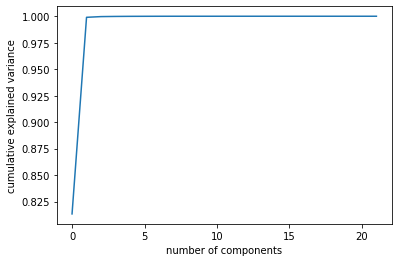

In [27]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In the figure above, less than 5 principal components are needed to explain the variance in the dataset.

In [28]:
pca = PCA(n_components = 0.99)
X_pca = pca.fit_transform(pca_data)
print(pca.n_components_)

2


The PCA identified 2 Principal Components that account for the explanation of 99% of the variability found in the dataset.

In [29]:
num_components = 2
pca = PCA(num_components)  
X_pca = pca.fit_transform(pca_data) 

In [30]:
n_pcs = pca.n_components_ 
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = pca_data.columns

most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

In [31]:
most_important_names

['gdp_per_capita', 'total_cases_per_million']

The PCA identified 'gdp_per_capita' and 'total_cases_per_million' as the most explanatory of the variability observed.

In [32]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print(pd.DataFrame(pca.components_, columns = pca_data.columns))

   total_cases_per_million  new_cases_smoothed_per_million  \
0                 0.197929                        0.002566   
1                 0.979827                        0.009838   

   total_deaths_per_million  new_deaths_smoothed_per_million  \
0                  0.004461                         0.000035   
1                  0.019345                         0.000186   

   reproduction_rate  icu_patients_per_million  hosp_patients_per_million  \
0      -2.756026e-07                  0.000282                   0.001929   
1      -4.749167e-06                  0.000472                   0.004274   

   weekly_icu_admissions_per_million  weekly_hosp_admissions_per_million  \
0                           0.000041                            0.000087   
1                           0.000193                            0.000268   

   total_tests_per_thousand  positive_rate  tests_per_case  stringency_index  \
0                  0.008098      -0.000001        0.002016         -0.000179   

The table above demonstrates the weights that each variable has on each component. The 'gdp_per_capita' is the most influential in the first component and 'total_cases_per_million' is the most influential on the second component. In the second component, the 'gdp_per_capita' has a negative influence.

##### 3.1.2.1. PCA plots

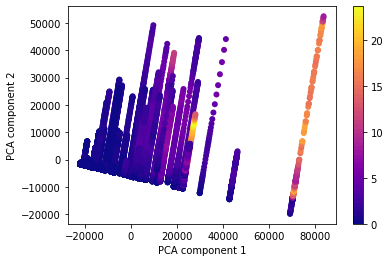

In [33]:
plt.scatter(X_pca[:, 0], X_pca[:, 1],
            c = normalize_data['new_tests_smoothed_per_thousand'], edgecolor='none', 
            cmap = plt.cm.get_cmap('plasma', 50))
plt.xlabel('PCA component 1')
plt.ylabel('PCA component 2')
plt.colorbar();

The plot above doesn't demonstrate a clear separation between the data, although we can perceive an increase in testing when the values of each component increment. Furthermore, it is noticeable along the increase of the values of the Principal Component 1 (majorly ruled by the 'gdp_per_capita' variable) that the corresponding value of the Principal Component 2 (majorly ruled by the 'total_cases_per_million' variable) decreases. This means that a higher value of 'gdp_per_capita' is associated with a higher number of testing and a smaller ratio of total cases per tests.

#### 3.1.3. PCA with de-trending

In [34]:
pca = PCA()
X_pca = pca.fit(data_diff_pca)

Text(0, 0.5, 'cumulative explained variance')

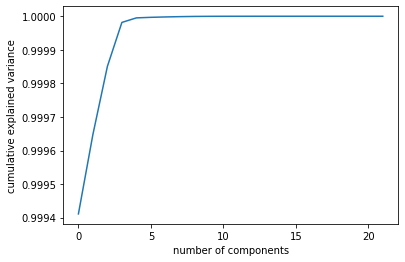

In [35]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In the figure above, less than 5 principal components are needed to explain the variance in the dataset.

In [36]:
pca = PCA(n_components = 0.99)
X_pca = pca.fit_transform(data_diff_pca)
print(pca.n_components_)

1


In [37]:
n_pcs = pca.n_components_ 
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
initial_feature_names = pca_data.columns

most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

In [38]:
most_important_names

['gdp_per_capita']

The PCA identified 'gdp_per_capita' as the most explanatory of the variability observed.

In [39]:
print(pd.DataFrame(pca.components_, columns = data_diff_pca.columns))

   total_cases_per_million  new_cases_smoothed_per_million  \
0                 0.002549                        0.000019   

   total_deaths_per_million  new_deaths_smoothed_per_million  \
0                  0.000034                     2.851663e-07   

   icu_patients_per_million  hosp_patients_per_million  \
0                  0.000002                   0.000013   

   weekly_icu_admissions_per_million  weekly_hosp_admissions_per_million  \
0                       7.820570e-10                       -2.637788e-09   

   total_tests_per_thousand  tests_per_case  reproduction_rate  positive_rate  \
0                  0.000082        0.000017      -1.107133e-07      -0.000001   

   stringency_index  population_density  median_age  aged_65_older  \
0         -0.000191            0.000174    0.000301       0.000215   

   aged_70_older  gdp_per_capita  extreme_poverty  hospital_beds_per_thousand  \
0       0.000149        0.999997        -0.000386                    0.000053   

   life_e

The table above demonstrates the weights that each variable has on the component. The 'gdp_per_capita' is the most influential.

##### 3.1.3.1. PCA plots

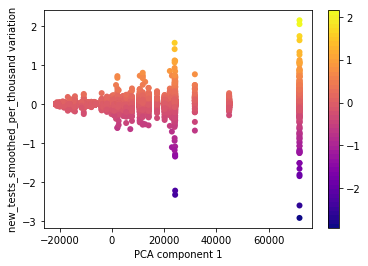

In [40]:
plt.scatter(X_pca[:, 0], new_tests_diff,
            c = normalize_data_diff['new_tests_smoothed_per_thousand'], edgecolor='none',
            cmap = plt.cm.get_cmap('plasma', 50))
plt.xlabel('PCA component 1')
plt.ylabel('new_tests_smoothed_per_thousand variation')
plt.colorbar();

In the plot above there isn't a clear separation of the data, but it appears to be organized in vertical stripes since the Principal Component 1 is heavily influenced by 'gdp_per_capita'. Most likely the vertical stripes are composed by countries with similar gdp values. With the increase of the principal component value there is also an increase in the variation of the variable 'new_tests_smoothed_per_thousand'.

Text(0, 0.5, 'new_tests_smoothed_per_thousand variation')

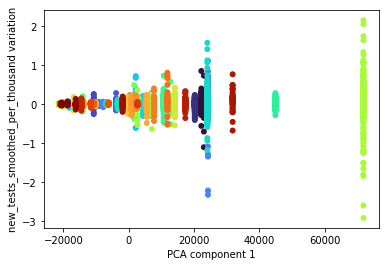

In [41]:
color_map = []
dic = {}

for i in range(normalize_data_diff['iso_code'].unique().size):
    dic[normalize_data_diff['iso_code'].unique()[i]] = i

for iso in normalize_data_diff['iso_code']:
    color_map.append(dic[iso])
    
plt.scatter(X_pca[:, 0], new_tests_diff,
            c = color_map, edgecolor='none', cmap = plt.cm.get_cmap('turbo', 50))
plt.xlabel('PCA component 1')
plt.ylabel('new_tests_smoothed_per_thousand variation')

Coloring the same plot by country confirmed our previous analysis: each vertical stripe represents a different country.

### 3.2. Hierarchical Clustering Dendrogram

#### 3.2.1.Data preparation

In [42]:
hierarc_data = normalize_data[['continent', 'location', 'total_cases_per_million', 'new_cases_smoothed_per_million',
                               'total_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate',
                               'icu_patients_per_million', 'hosp_patients_per_million',
                               'weekly_icu_admissions_per_million', 'weekly_hosp_admissions_per_million',
                               'total_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'positive_rate',
                               'tests_per_case', 'stringency_index', 'population_density', 'median_age',
                               'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
                               'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index']]

In [43]:
last_day_hierarc_data = pd.DataFrame(columns = ['continent', 'location', 'total_cases_per_million',
                                                'new_cases_smoothed_per_million',
                               'total_deaths_per_million', 'new_deaths_smoothed_per_million', 'reproduction_rate',
                               'icu_patients_per_million', 'hosp_patients_per_million',
                               'weekly_icu_admissions_per_million', 'weekly_hosp_admissions_per_million',
                               'total_tests_per_thousand', 'new_tests_smoothed_per_thousand', 'positive_rate',
                               'tests_per_case', 'stringency_index', 'population_density', 'median_age',
                               'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
                               'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index'])

for country in hierarc_data.location.unique():
    last_day_hierarc_data = last_day_hierarc_data.append(hierarc_data[hierarc_data.location == country].iloc[-1, :])

In [44]:
last_day_hierarc_data.head()

,continent,location,total_cases_per_million,new_cases_smoothed_per_million,total_deaths_per_million,new_deaths_smoothed_per_million,reproduction_rate,icu_patients_per_million,hosp_patients_per_million,weekly_icu_admissions_per_million,weekly_hosp_admissions_per_million,total_tests_per_thousand,new_tests_smoothed_per_thousand,positive_rate,tests_per_case,stringency_index,population_density,median_age,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,hospital_beds_per_thousand,life_expectancy,human_development_index
2020-12-30,Oceania,Australia,1113.927,0.801,35.647,0.006,1.19,0.000,0.000,0.0,0.0,439.388,2.180,0.000,2721.2,68.06,3.202,37.9,15.504,10.129,44648.710,0.5,3.84,83.44,0.939
2020-12-30,Europe,Austria,39738.630,214.847,682.737,7.852,0.92,43.858,223.397,0.0,0.0,423.047,2.030,0.106,9.4,78.70,106.749,44.4,19.202,13.748,45436.686,0.7,7.37,81.54,0.908
2020-12-13,Asia,Bangladesh,2978.534,11.266,42.820,0.186,0.84,0.000,0.000,0.0,0.0,18.019,0.092,0.122,8.2,80.09,1265.036,27.5,5.098,3.262,3523.984,14.8,0.80,72.59,0.608
2020-12-30,Europe,Belgium,55587.864,146.942,1677.450,6.188,0.89,42.711,201.387,0.0,0.0,598.284,2.272,0.073,13.7,60.19,375.564,41.8,18.571,12.849,42658.576,0.2,5.64,81.63,0.916
2020-12-30,South America,Bolivia,13567.344,77.199,783.773,1.028,1.57,0.000,0.000,0.0,0.0,35.165,0.197,0.392,2.6,52.78,10.202,25.4,6.704,4.393,6885.829,7.1,1.10,71.51,0.693


#### 3.2.2. Construction of the clustering dendrogram 

In [45]:
# Do the clustering
Z = hac.linkage(last_day_hierarc_data.iloc[:, 2:], method = 'single', metric = 'correlation',
                optimal_ordering = True)

Z_av = hac.linkage(last_day_hierarc_data.iloc[:, 2:], method = 'average', metric = 'correlation',
                   optimal_ordering = True)

In [46]:
dic_color = {'Oceania': 'black',
             'Europe': 'tab:cyan',
             'Asia': 'tab:orange',
             'South America': 'tab:red',
             'North America': 'tab:green',
             'Africa': 'tab:purple'}

dic_color_country = {}
for country in hierarc_data.location.unique():
    continent = hierarc_data[hierarc_data.location == country].continent.unique()[0]
    dic_color_country[country] = dic_color[continent]

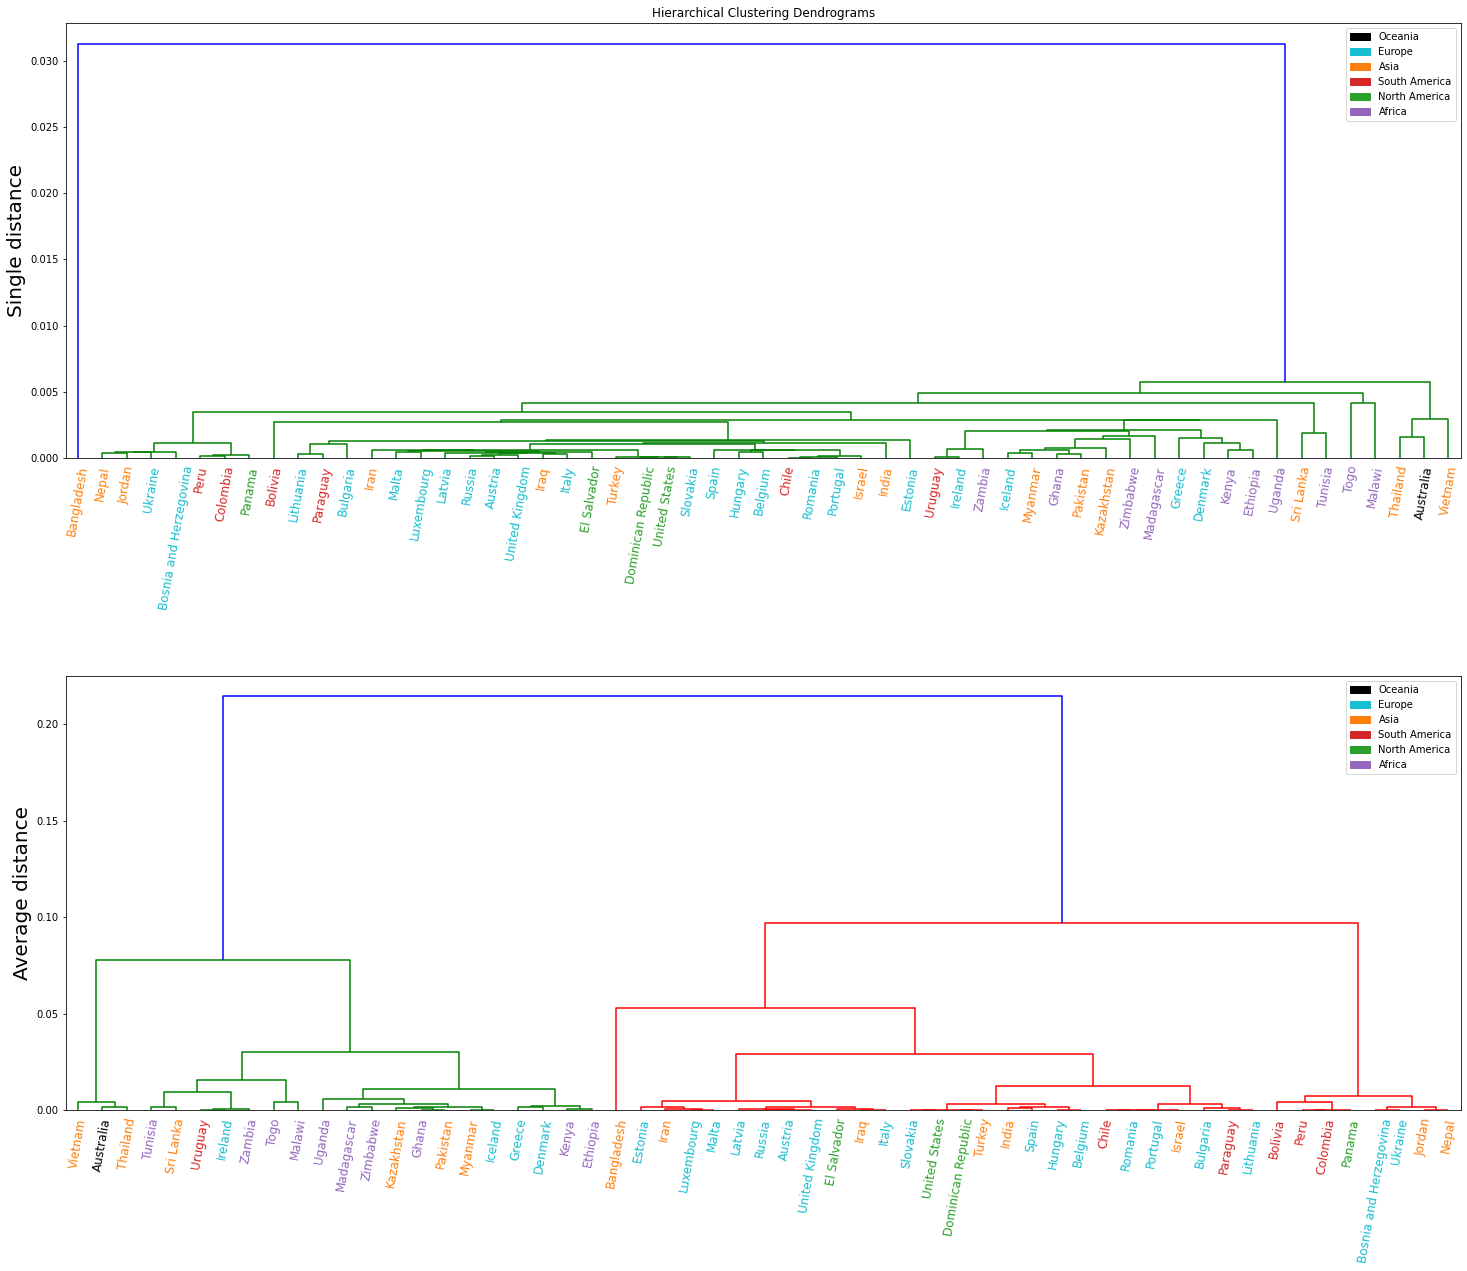

In [47]:
# Plot dendrogram
import matplotlib.patches as mpatches
fig, ax = plt.subplots(2, 1, figsize=(25, 20))
Z_dnd = hac.dendrogram(Z,
                       leaf_rotation=80.,
                       leaf_font_size=12.,  # font size for the x axis labels
                       orientation='top',
                       ax = ax[0],
                       labels = last_day_hierarc_data.location)
Z_av_dnd = hac.dendrogram(Z_av,
                          leaf_rotation=80.,  # rotates the x axis labels
                          leaf_font_size=12.,  # font size for the x axis labels
                          orientation='top',
                          ax = ax[1],
                          labels = last_day_hierarc_data.location)
ax[0].set_title('Hierarchical Clustering Dendrograms')
ax[0].set_ylabel('Single distance', fontsize = 20)
ax[1].set_ylabel('Average distance', fontsize = 20)
plt.subplots_adjust(hspace = 0.5)

Oceania = mpatches.Patch(color = dic_color['Oceania'], label = 'Oceania')
Europe = mpatches.Patch(color = dic_color['Europe'], label = 'Europe')
Asia = mpatches.Patch(color = dic_color['Asia'], label = 'Asia')
South_America = mpatches.Patch(color = dic_color['South America'], label = 'South America')
North_America = mpatches.Patch(color = dic_color['North America'], label = 'North America')
Africa = mpatches.Patch(color = dic_color['Africa'], label = 'Africa')

ax[0].legend(handles = [Oceania, Europe, Asia, South_America, North_America, Africa])
ax[1].legend(handles = [Oceania, Europe, Asia, South_America, North_America, Africa])

xlabels_Z = ax[0].get_xmajorticklabels()
xlabels_Z_av = ax[1].get_xmajorticklabels()

for x_labels in (xlabels_Z, xlabels_Z_av):
    for labels in x_labels:
        labels.set_color(dic_color_country[labels.get_text()])
        
plt.show()

The first hierarchical clustering dendrogram was performed with 'single distance' metric. It does not demonstrate a clear separation between countries per continent.

The second dendrogram was performed with 'average distance' metric. In this case, although not explicit, it is possible to see a slight separation of countries per continent.

In [48]:
def print_clusters(hierarc_data, Z, k, plot=False):
    # k Number of clusters we'd like to extract
    results = fcluster(Z, k, criterion='maxclust')
    # check the results
    s = pd.Series(results)
    clusters = s.unique()
    for c in clusters:
        cluster_indeces = s[s==c].index
        print("Cluster %d number of entries %d" % (c, len(cluster_indeces)))
        if plot:
            timeSeries.T.iloc[:,cluster_indeces].plot()
            plt.show()
            
print_clusters(hierarc_data, Z, 6, plot=False)

Cluster 5 number of entries 3
Cluster 1 number of entries 49
Cluster 6 number of entries 1
Cluster 4 number of entries 1
Cluster 2 number of entries 2
Cluster 3 number of entries 1


In [49]:
print_clusters(hierarc_data, Z_av, 6, plot=False)

Cluster 1 number of entries 3
Cluster 4 number of entries 26
Cluster 5 number of entries 1
Cluster 6 number of entries 8
Cluster 3 number of entries 12
Cluster 2 number of entries 7


The prementioned is clear when we look at the number of entries per cluster for each dendrogram made.

## 4. Supervised Machine Learning


- **Variable to predict - 'new_tests_smoothed_per_thousand'**


We want to analyse the testing data, and as such, it is intended throughout this section to create models capable of predicting the variable 'new_tests_smoothed_per_thousand'.
We choose this variable because of its  ration fashion (value per thousand), making it comparable between countries, and because of its accountability for the appearance of sudden spikes as a result of an update of testing data from weekend report.

### 4.1. Datasets Preparation

In [50]:
normalize_data['location'].unique()

array(['Australia', 'Austria', 'Bangladesh', 'Belgium', 'Bolivia',
       'Bosnia and Herzegovina', 'Bulgaria', 'Chile', 'Colombia',
       'Denmark', 'Dominican Republic', 'El Salvador', 'Estonia',
       'Ethiopia', 'Ghana', 'Greece', 'Hungary', 'Iceland', 'India',
       'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Jordan',
       'Kazakhstan', 'Kenya', 'Latvia', 'Lithuania', 'Luxembourg',
       'Madagascar', 'Malawi', 'Malta', 'Myanmar', 'Nepal', 'Pakistan',
       'Panama', 'Paraguay', 'Peru', 'Portugal', 'Romania', 'Russia',
       'Slovakia', 'Spain', 'Sri Lanka', 'Thailand', 'Togo', 'Tunisia',
       'Turkey', 'Uganda', 'Ukraine', 'United Kingdom', 'United States',
       'Uruguay', 'Vietnam', 'Zambia', 'Zimbabwe'], dtype=object)

In [51]:
countries = []

for continent in normalize_data['continent'].unique():
    df = normalize_data[normalize_data['continent'] == continent]
    max_gdp = df['gdp_per_capita'].max()
    countries.append(df[df['gdp_per_capita'] == max_gdp]['location'].unique()[0])
        
print(countries)

['Australia', 'Luxembourg', 'Israel', 'Chile', 'United States', 'Tunisia']


In order to select some countries to construct models, we decided to choose the countries with the highest gdp_per_capita value per continent.

In [52]:
for country in countries:
    n_entries = normalize_data[normalize_data['location'] == country].shape[0]
    print(country, ': ', n_entries, ' entries', sep = '')

Australia: 226 entries
Luxembourg: 281 entries
Israel: 286 entries
Chile: 266 entries
United States: 43 entries
Tunisia: 173 entries


The country United States only has 43 entries. To build models 200 entries are not ideal, less than 100 will not be acceptable for the construction of the models - they will present bad metrics because of lack of data.

### 4.2. Construction of the models

#### 4.2.1. Functions

In order to agile and optimize de code and process of implementation of the ML models to the respective dataset of the countries chosen we decided to implement some functions:

- ml_transform_df - prepare the dataset by adding columns with data from previous days (timeseries requires previous values), like a sliding window;
- train_test_split_df - split the resulting dataset from running the previous function in train and test;
- model_construction_rf - construct a Random Forest Regressor model;
- model_construction_en - construct an Elastic Net model;
- model_construction_gb - construct a Gradient Boosting Regressor mode;
- rmse - construct the metric rmse;
- regression_results - present and calculate all the metric results;
- plot_ml - plot the model results;

In [53]:
#Dataset Preparation
def ml_transform_df(df_country, n_past = 7):   
    # Number of days we want to predict into the future = 1
    # Number of days we want to base the prediction = 7
    df_ml = []
    for i in range(n_past, len(df_country)):
        day_i = df_country.iloc[i, 0:df_country.shape[1]-1].values
        t_past = df_country['new_tests_smoothed_per_thousand'][i - n_past:i].values
        t_future = df_country['new_tests_smoothed_per_thousand'][i]
        day = np.concatenate((day_i, t_past, t_future), axis=None)
        df_ml.append(day)

    df_ml = np.array(df_ml)
    df_ml = pd.DataFrame(columns = ['total_cases_per_million', 'new_cases_smoothed_per_million', 
                                    'new_deaths_smoothed_per_million', 'total_tests_per_thousand', 'positive_rate', 
                                    'stringency_index', 'ntests_t7', 'ntests_t6', 'ntests_t5', 'ntests_t4', 
                                    'ntests_t3', 'ntests_t2', 'ntests_t1', 'new_tests_smoothed_per_thousand'],
                         data = df_ml)

    df_ml = df_ml.set_index(df_country.index[-df_ml.shape[0]:])
    return df_ml

def train_test_split_df(df_scaled, perc = 0.85):
    split_index = round(df_scaled.shape[0]*perc)
    
    Xtrain = df_scaled[:split_index, :-1]
    Ytrain = df_scaled[:split_index, -1]
    
    Xtest = df_scaled[split_index:, :-1]
    Ytest = df_scaled[split_index:, -1]
    return (Xtrain, Ytrain, Xtest, Ytest)

The sliding window method, applied to the dataset with the function 'ml_transform_df()' consists of, based on values of n days before the instance t, predict the instance.
This means that, for each entry, besides all values for the other variables, the values of the variable 'new_tests_smoothed_per_thousand' from the previous n days will be included.

Each entry of the dataset will present this shape (new_tests_smoothed_per_thousand = ntst):
                                                                               
    entriy 1 | feature 1, .....,  ntst(t-n), ntst(t-n-1), ntst(t-n-2), ....., ntst(t) |
    entriy 2 | feature 1, .....,  ntst(t-n), ntst(t-n-1), ntst(t-n-2), ....., ntst(t) |
    entriy 3 | feature 1, .....,  ntst(t-n), ntst(t-n-1), ntst(t-n-2), ....., ntst(t) |
    
shape - ( total number of entries, (number of features of the original dataset + n) )

In [54]:
#Machine Learning Models
def model_construction_rf(Xtrain, Ytrain, Xtest): 
    model = RandomForestRegressor()
    param_search = { 
        'n_estimators': [20, 50, 100],
        'max_features': ['auto', 'sqrt', 'log2'],
        'max_depth' : [i for i in range(5,15)]
    }
    tscv = TimeSeriesSplit()
    gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
    gsearch.fit(Xtrain, Ytrain) 
    best_score = gsearch.best_score_ 
    best_model = gsearch.best_estimator_
    y_pred = best_model.predict(Xtest)
    return (best_score, best_model, y_pred)

def model_construction_en(Xtrain, Ytrain, Xtest):
    model = ElasticNet()
    param_search = {'alpha': [0.01, 0.1, 1] , 'l1_ratio':[0.1, 0.2, 0.4, 0.6, 0.8, 0.9]}
    tscv = TimeSeriesSplit()
    gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
    gsearch.fit(Xtrain, Ytrain) 
    best_score = gsearch.best_score_ 
    best_model = gsearch.best_estimator_
    y_pred = best_model.predict(Xtest)
    return (best_score, best_model, y_pred)

def model_construction_gb(Xtrain, Ytrain, Xtest):
    model = GradientBoostingRegressor()
    param_search = {'n_estimators': [100, 200, 500],
                    'n_iter_no_change': [5, 10],
                    'validation_fraction': [0.5, 0.2, 0.1]}
    tscv = TimeSeriesSplit()
    gsearch = GridSearchCV(estimator = model, cv = tscv, param_grid = param_search, scoring = adjr2_score)
    gsearch.fit(Xtrain, Ytrain) 
    best_score = gsearch.best_score_ 
    best_model = gsearch.best_estimator_
    y_pred = best_model.predict(Xtest)
    return (best_score, best_model, y_pred)

In [55]:
def rmse(actual, predict):
    predict = np.array(predict)
    actual = np.array(actual)
    distance = predict - actual
    square_distance = distance ** 2
    mean_square_distance = square_distance.mean()
    score = np.sqrt(mean_square_distance)
    return score

rmse_score = make_scorer(rmse, greater_is_better = False)

def regression_results(y_true, y_pred):
    explained_variance = metrics_ml.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics_ml.mean_absolute_error(y_true, y_pred) 
    mse = metrics_ml.mean_squared_error(y_true, y_pred) 
    median_absolute_error = metrics_ml.median_absolute_error(y_true, y_pred)
    r2 = metrics_ml.r2_score(y_true, y_pred)
    adj_r2 = adjr2(y_true, y_pred)
    print('explained_variance: ', round(explained_variance,4))    
    print('r2: ', round(r2,4))
    print('adj r2: ', round(adj_r2, 4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))

In [56]:
def plot_ml(df_ml, country, y_pred, perc = 0.15):
    test_index = round(df_ml.shape[0]*perc)
    #Plot
    plt.figure(figsize=(16,8))
    plt.plot(country.index[:-test_index], country.iloc[:-test_index,-1], label = 'Train')
    plt.plot(country.index[-test_index:], y_pred, label = 'Predicted')
    plt.plot(country.index[-test_index:], country.iloc[-test_index:,-1], label = 'Test')
    plt.legend()
    plt.show()

We will construct the ML models for the countries datasets and plot the results for the prediction of the variable 'new_tests_smoothed_per_thousand'. To perform the correct ML analysis for each country, the timeseries should be stationary, and for that reason we will construct models only with differenced datasets (this construction was performed earlier in this pipeline - section '2.4.1.1. Differencing the dataset').

#### 4.2.2. Models

- **Australia**

In [57]:
def adjr2(actual, predict):
    r2 = metrics_ml.r2_score(actual, predict)
    n = Australia.shape[0]
    p = Australia.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

In [58]:
#Dataset diff
Australia = normalize_data_diff[normalize_data_diff['location'] == 'Australia']
Australia = Australia[['total_cases_per_million', 'new_cases_smoothed_per_million',
                       'new_deaths_smoothed_per_million', 'total_tests_per_thousand', 
                       'positive_rate', 'stringency_index','new_tests_smoothed_per_thousand']] 

#transform dataset
df_ml_Australia = ml_transform_df(Australia)

#Scalling values
df_ml_val_australia = df_ml_Australia.values
scaler_df = StandardScaler()
scaler_df = scaler_df.fit(df_ml_val_australia)
df_scaled_Australia = scaler_df.transform(df_ml_val_australia)

#Train Test split
(Xtrain_Australia, Ytrain_Australia, Xtest_Australia, Ytest_Australia) = train_test_split_df(df_scaled_Australia)

explained_variance:  0.2702
r2:  0.2697
adj r2:  0.2461
MAE:  0.979
MSE:  2.3112
RMSE:  1.5203


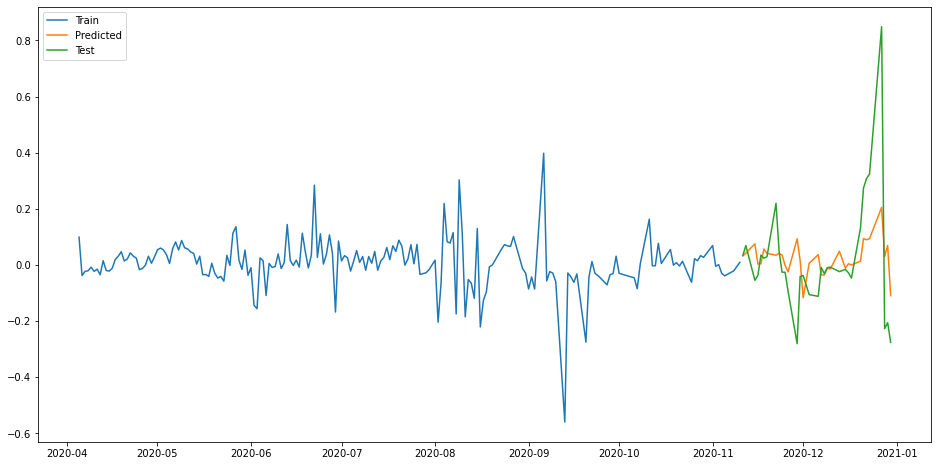

In [59]:
#Construct model Random Forest
(best_score_rf_Australia, best_model_rf_Australia, 
 y_pred_rf_Australia) = model_construction_rf(Xtrain_Australia, Ytrain_Australia, Xtest_Australia)
regression_results(Ytest_Australia, y_pred_rf_Australia)

#Invert scalling
forecast_copies = np.repeat(np.array(y_pred_rf_Australia).reshape(Ytest_Australia.shape[0],1), df_ml_Australia.shape[1], axis = -1)
y_pred_rf_Australia_fut = scaler_df.inverse_transform(forecast_copies)[:,-1]

plot_ml(df_ml_Australia, Australia, y_pred_rf_Australia_fut)

explained_variance:  0.1511
r2:  0.1459
adj r2:  0.1184
MAE:  1.0784
MSE:  2.7028
RMSE:  1.644


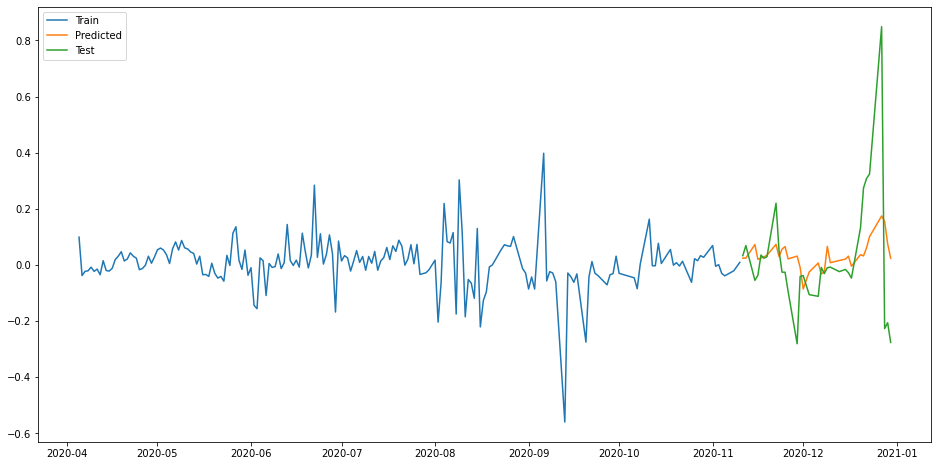

In [60]:
#Construct model Elastic Net
(best_score_en_Australia, best_model_en_Australia, 
 y_pred_en_Australia) = model_construction_en(Xtrain_Australia, Ytrain_Australia, Xtest_Australia)
regression_results(Ytest_Australia, y_pred_en_Australia)

#Invert scalling
forecast_copies = np.repeat(np.array(y_pred_en_Australia).reshape(Ytest_Australia.shape[0],1), df_ml_Australia.shape[1], axis = -1)
y_pred_en_Australia_fut = scaler_df.inverse_transform(forecast_copies)[:,-1]

plot_ml(df_ml_Australia, Australia, y_pred_en_Australia_fut)

explained_variance:  0.3138
r2:  0.3114
adj r2:  0.2892
MAE:  1.0194
MSE:  2.1792
RMSE:  1.4762


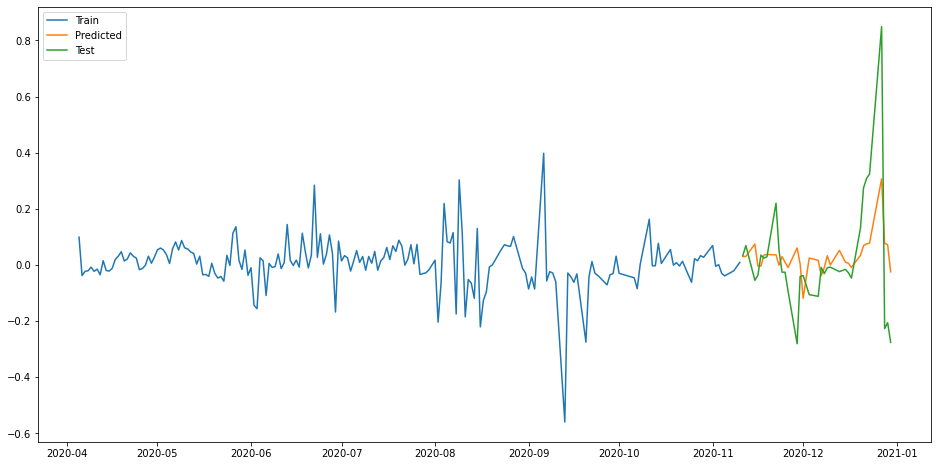

In [61]:
#Construct model Gradient Boosting
(best_score_gb_Australia, best_model_gb_Australia, 
 y_pred_gb_Australia) = model_construction_gb(Xtrain_Australia, Ytrain_Australia, Xtest_Australia)
regression_results(Ytest_Australia, y_pred_gb_Australia)

#Invert scalling
forecast_copies = np.repeat(np.array(y_pred_gb_Australia).reshape(Ytest_Australia.shape[0],1), df_ml_Australia.shape[1], axis = -1)
y_pred_gb_Australia_fut = scaler_df.inverse_transform(forecast_copies)[:,-1]

plot_ml(df_ml_Australia, Australia, y_pred_gb_Australia_fut)

The model with the better performance on the Australia dataset is the Gradient Boosting Regressor. But not one of the models presents an acceptable performance.

- **Luxembourg**

In [62]:
def adjr2(actual, predict):
    r2 = metrics_ml.r2_score(actual, predict)
    n = Luxembourg.shape[0]
    p = Luxembourg.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

In [63]:
#Dataset
Luxembourg = normalize_data_diff[normalize_data_diff['location'] == 'Luxembourg']
Luxembourg = Luxembourg[['total_cases_per_million', 'new_cases_smoothed_per_million',
                       'new_deaths_smoothed_per_million', 'total_tests_per_thousand', 
                       'positive_rate', 'stringency_index','new_tests_smoothed_per_thousand']] 

#transform dataset
df_ml_Luxembourg = ml_transform_df(Luxembourg)

#Scalling values
df_ml_val_Luxembourg = df_ml_Luxembourg.values
scaler_df = StandardScaler()
scaler_df = scaler_df.fit(df_ml_val_australia)
df_scaled_Luxembourg = scaler_df.transform(df_ml_val_Luxembourg)

#Train Test split
(Xtrain_Luxembourg, Ytrain_Luxembourg, Xtest_Luxembourg, Ytest_Luxembourg) = train_test_split_df(df_scaled_Luxembourg)

explained_variance:  0.3494
r2:  0.1212
adj r2:  0.0986
MAE:  3.7666
MSE:  35.3965
RMSE:  5.9495


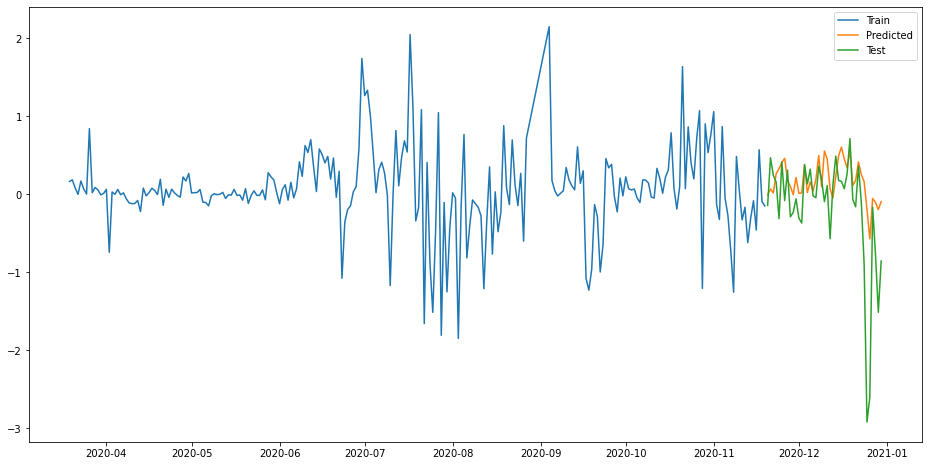

In [64]:
#Construct model Random Forest
(best_score_rf_Luxembourg, best_model_rf_Luxembourg, 
 y_pred_rf_Luxembourg) = model_construction_rf(Xtrain_Luxembourg, Ytrain_Luxembourg, Xtest_Luxembourg)
regression_results(Ytest_Luxembourg, y_pred_rf_Luxembourg)

#Invert scalling
forecast_copies = np.repeat(np.array(y_pred_rf_Luxembourg).reshape(Ytest_Luxembourg.shape[0],1), df_ml_Luxembourg.shape[1], axis = -1)
y_pred_rf_Luxembourg_fut = scaler_df.inverse_transform(forecast_copies)[:,-1]

plot_ml(df_ml_Luxembourg, Luxembourg, y_pred_rf_Luxembourg_fut)

explained_variance:  0.3376
r2:  -0.0046
adj r2:  -0.0305
MAE:  4.348
MSE:  40.4644
RMSE:  6.3612


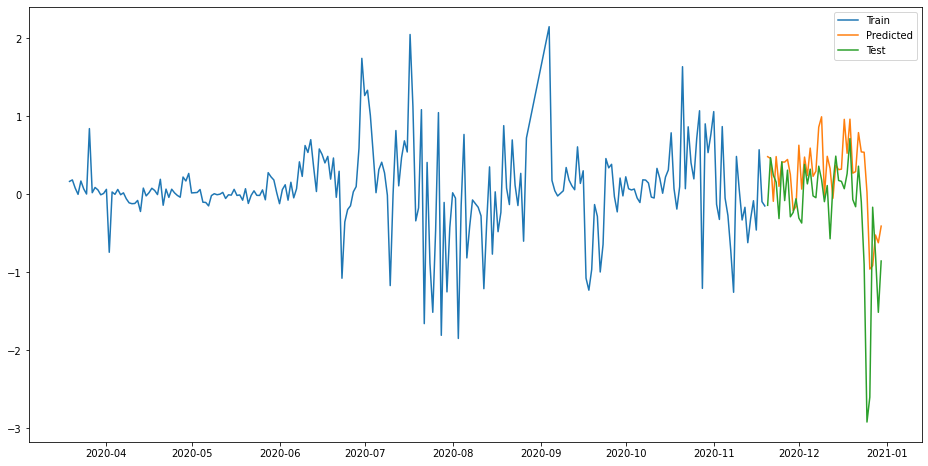

In [65]:
#Construct model Elastic Net
(best_score_en_Luxembourg, best_model_en_Luxembourg, 
 y_pred_en_Luxembourg) = model_construction_en(Xtrain_Luxembourg, Ytrain_Luxembourg, Xtest_Luxembourg)
regression_results(Ytest_Luxembourg, y_pred_en_Luxembourg)

#Invert scalling
forecast_copies = np.repeat(np.array(y_pred_en_Luxembourg).reshape(Ytest_Luxembourg.shape[0],1), df_ml_Luxembourg.shape[1], axis = -1)
y_pred_en_Luxembourg_fut = scaler_df.inverse_transform(forecast_copies)[:,-1]

plot_ml(df_ml_Luxembourg, Luxembourg, y_pred_en_Luxembourg_fut)

explained_variance:  0.323
r2:  0.0685
adj r2:  0.0445
MAE:  3.9702
MSE:  37.5183
RMSE:  6.1252


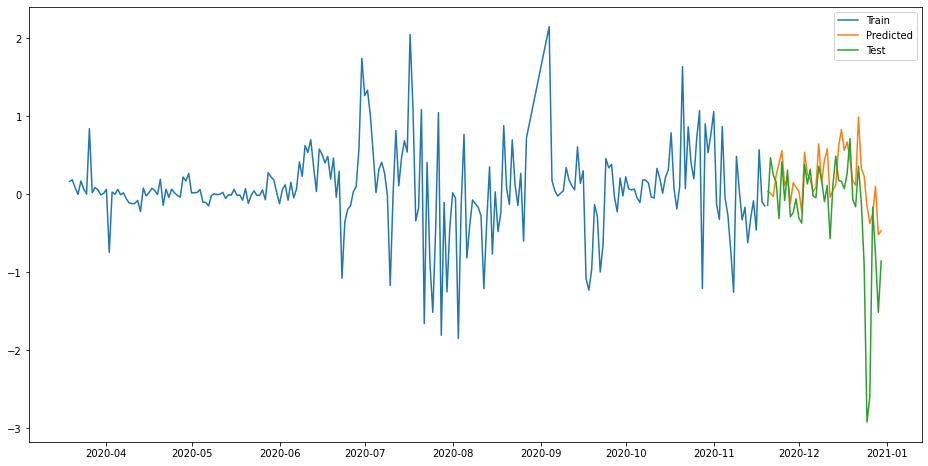

In [66]:
#Construct model Gradient Boosting
(best_score_gb_Luxembourg, best_model_gb_Luxembourg, 
 y_pred_gb_Luxembourg) = model_construction_gb(Xtrain_Luxembourg, Ytrain_Luxembourg, Xtest_Luxembourg)
regression_results(Ytest_Luxembourg, y_pred_gb_Luxembourg)

#Invert scalling
forecast_copies = np.repeat(np.array(y_pred_gb_Luxembourg).reshape(Ytest_Luxembourg.shape[0],1), df_ml_Luxembourg.shape[1], axis = -1)
y_pred_gb_Luxembourg_fut = scaler_df.inverse_transform(forecast_copies)[:,-1]

plot_ml(df_ml_Luxembourg, Luxembourg, y_pred_gb_Luxembourg_fut)

The model with the better performance on the Luxembourg dataset is the Random Forest Regressor. But not one of the models presents an acceptable performance. There is even the presence of negative squared values.

- **Israel**

In [67]:
def adjr2(actual, predict):
    r2 = metrics_ml.r2_score(actual, predict)
    n = Israel.shape[0]
    p = Israel.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

In [68]:
#Dataset diff
Israel = normalize_data_diff[normalize_data_diff['location'] == 'Israel']
Israel = Israel[['total_cases_per_million', 'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 
                 'total_tests_per_thousand', 'positive_rate', 'stringency_index','new_tests_smoothed_per_thousand']] 

#transform dataset
df_ml_Israel = ml_transform_df(Israel)

#Scalling values
df_ml_val_Israel = df_ml_Israel.values
scaler_df = StandardScaler()
scaler_df = scaler_df.fit(df_ml_val_Israel)
df_scaled_Israel = scaler_df.transform(df_ml_val_Israel)

#Train Test split
(Xtrain_Israel, Ytrain_Israel, Xtest_Israel, Ytest_Israel) = train_test_split_df(df_scaled_Israel)

explained_variance:  -0.282
r2:  -0.4744
adj r2:  -0.5117
MAE:  0.7431
MSE:  1.0543
RMSE:  1.0268


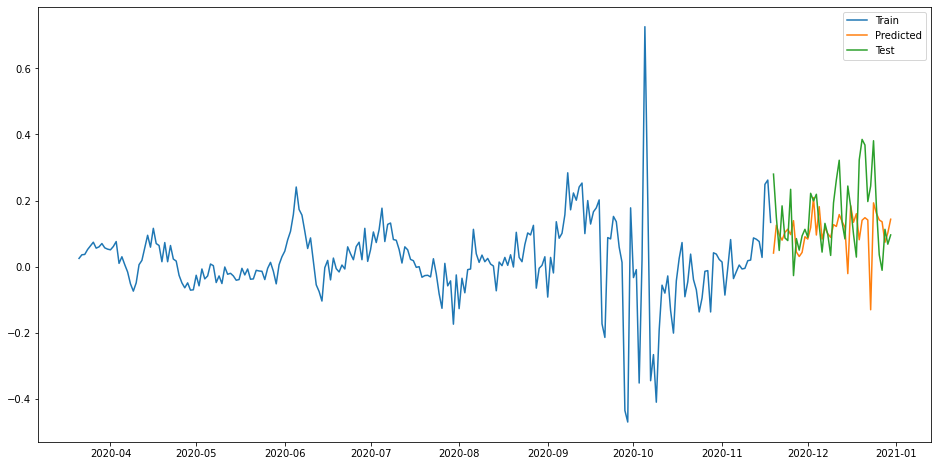

In [69]:
#Construct model Random Forest
(best_score_rf_Israel, best_model_rf_Israel, 
 y_pred_rf_Israel) = model_construction_rf(Xtrain_Israel, Ytrain_Israel, Xtest_Israel)
regression_results(Ytest_Israel, y_pred_rf_Israel)

#Invert scalling
forecast_copies = np.repeat(np.array(y_pred_rf_Israel).reshape(Ytest_Israel.shape[0],1), df_ml_Israel.shape[1], axis = -1)
y_pred_rf_Israel_fut = scaler_df.inverse_transform(forecast_copies)[:,-1]

plot_ml(df_ml_Israel, Israel, y_pred_rf_Israel_fut)

explained_variance:  -0.5247
r2:  -0.8571
adj r2:  -0.9041
MAE:  0.9032
MSE:  1.328
RMSE:  1.1524


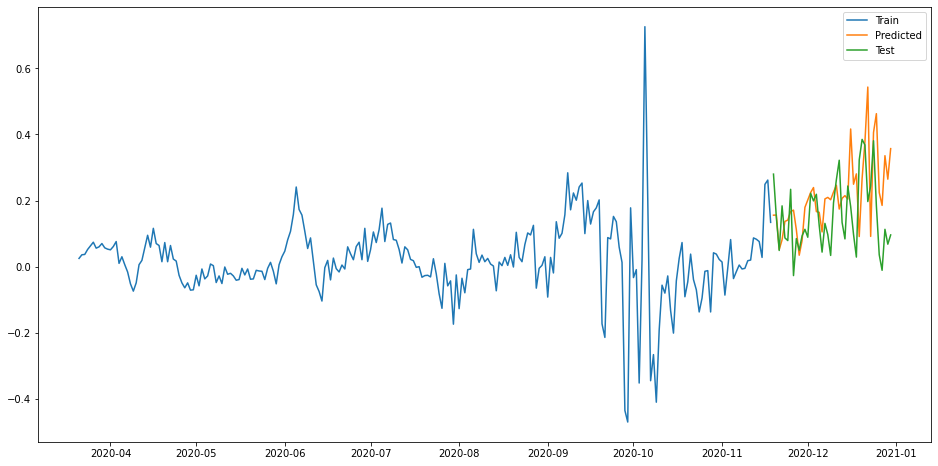

In [70]:
#Construct model Elastic Net
(best_score_en_Israel, best_model_en_Israel, 
 y_pred_en_Israel) = model_construction_en(Xtrain_Israel, Ytrain_Israel, Xtest_Israel)
regression_results(Ytest_Israel, y_pred_en_Israel)

#Invert scalling
forecast_copies = np.repeat(np.array(y_pred_en_Israel).reshape(Ytest_Israel.shape[0],1), df_ml_Israel.shape[1], axis = -1)
y_pred_en_Israel_fut = scaler_df.inverse_transform(forecast_copies)[:,-1]

plot_ml(df_ml_Israel, Israel, y_pred_en_Israel_fut)

explained_variance:  -0.0786
r2:  -0.0846
adj r2:  -0.112
MAE:  0.7024
MSE:  0.7756
RMSE:  0.8807


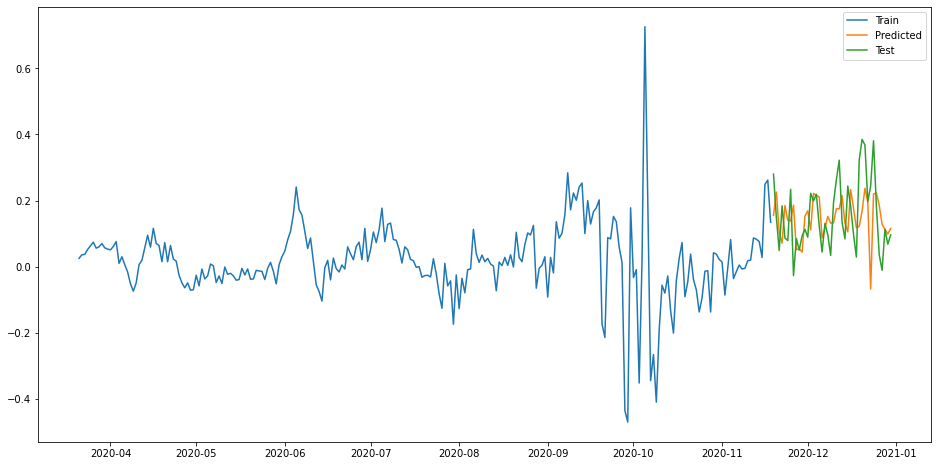

In [71]:
#Construct model Gradient Boosting
(best_score_gb_Israel, best_model_gb_Israel, 
 y_pred_gb_Israel) = model_construction_gb(Xtrain_Israel, Ytrain_Israel, Xtest_Israel)
regression_results(Ytest_Israel, y_pred_gb_Israel)

#Invert scalling
forecast_copies = np.repeat(np.array(y_pred_gb_Israel).reshape(Ytest_Israel.shape[0],1), df_ml_Israel.shape[1], axis = -1)
y_pred_gb_Israel_fut = scaler_df.inverse_transform(forecast_copies)[:,-1]

plot_ml(df_ml_Israel, Israel, y_pred_gb_Israel_fut)

No model presents a comparable performance on the Israel dataset. The 'r squared' value is negative across all models.

- **Chile**

In [72]:
def adjr2(actual, predict):
    r2 = metrics_ml.r2_score(actual, predict)
    n = Chile.shape[0]
    p = Chile.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

In [73]:
#Dataset diff
Chile = normalize_data_diff[normalize_data_diff['location'] == 'Chile']
Chile = Israel[['total_cases_per_million', 'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 
                 'total_tests_per_thousand', 'positive_rate', 'stringency_index','new_tests_smoothed_per_thousand']] 

#transform dataset
df_ml_Chile = ml_transform_df(Chile)

#Scalling values
df_ml_val_Chile = df_ml_Chile.values
scaler_df = StandardScaler()
scaler_df = scaler_df.fit(df_ml_val_Chile)
df_scaled_Chile = scaler_df.transform(df_ml_val_Chile)

#Train Test split
(Xtrain_Chile, Ytrain_Chile, Xtest_Chile, Ytest_Chile) = train_test_split_df(df_scaled_Chile)

explained_variance:  -0.3274
r2:  -0.4255
adj r2:  -0.4615
MAE:  0.7521
MSE:  1.0193
RMSE:  1.0096


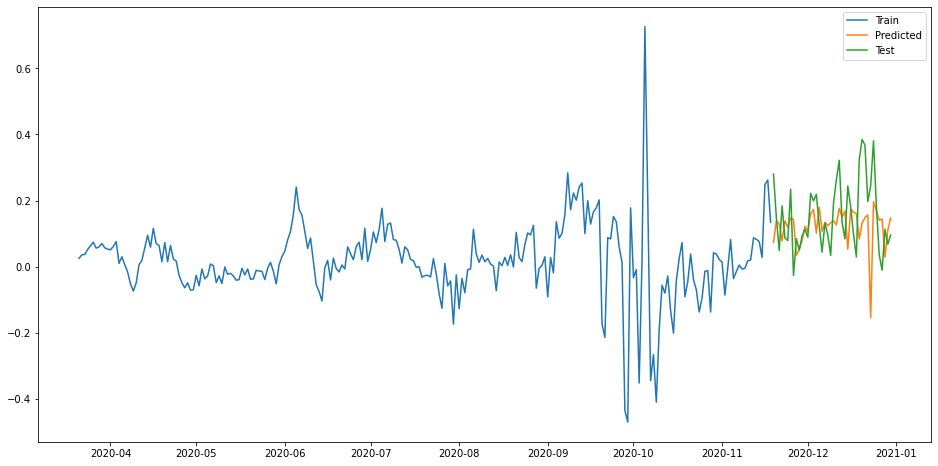

In [74]:
#Construct model Random Forest
(best_score_rf_Chile, best_model_rf_Chile, 
 y_pred_rf_Chile) = model_construction_rf(Xtrain_Chile, Ytrain_Chile, Xtest_Chile)
regression_results(Ytest_Chile, y_pred_rf_Chile)

#Invert scalling
forecast_copies = np.repeat(np.array(y_pred_rf_Chile).reshape(Ytest_Chile.shape[0],1), df_ml_Chile.shape[1], axis = -1)
y_pred_rf_Chile_fut = scaler_df.inverse_transform(forecast_copies)[:,-1]

plot_ml(df_ml_Chile, Chile, y_pred_rf_Chile_fut)

explained_variance:  -0.5247
r2:  -0.8571
adj r2:  -0.9041
MAE:  0.9032
MSE:  1.328
RMSE:  1.1524


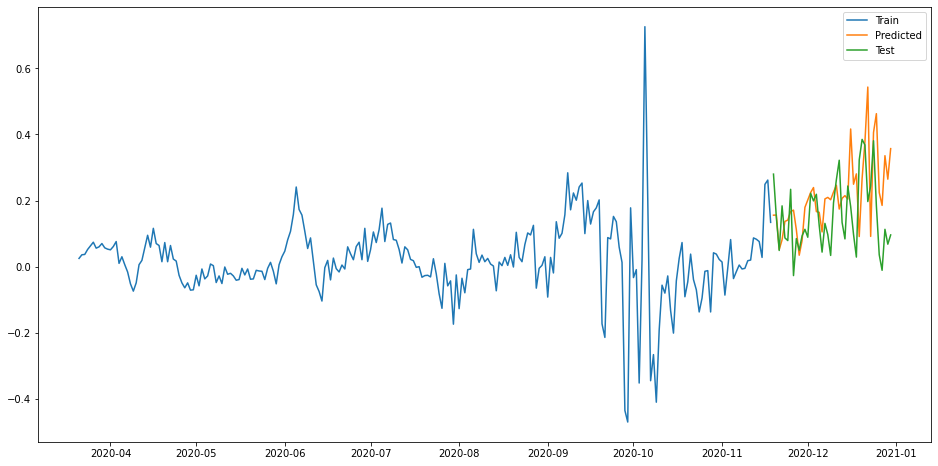

In [75]:
#Construct model Elastic Net
(best_score_en_Chile, best_model_en_Chile, 
 y_pred_en_Chile) = model_construction_en(Xtrain_Chile, Ytrain_Chile, Xtest_Chile)
regression_results(Ytest_Chile, y_pred_en_Chile)

#Invert scalling
forecast_copies = np.repeat(np.array(y_pred_en_Chile).reshape(Ytest_Chile.shape[0],1), df_ml_Chile.shape[1], axis = -1)
y_pred_en_Chile_fut = scaler_df.inverse_transform(forecast_copies)[:,-1]

plot_ml(df_ml_Chile, Chile, y_pred_en_Chile_fut)

explained_variance:  -0.72
r2:  -0.9602
adj r2:  -1.0098
MAE:  0.855
MSE:  1.4017
RMSE:  1.184


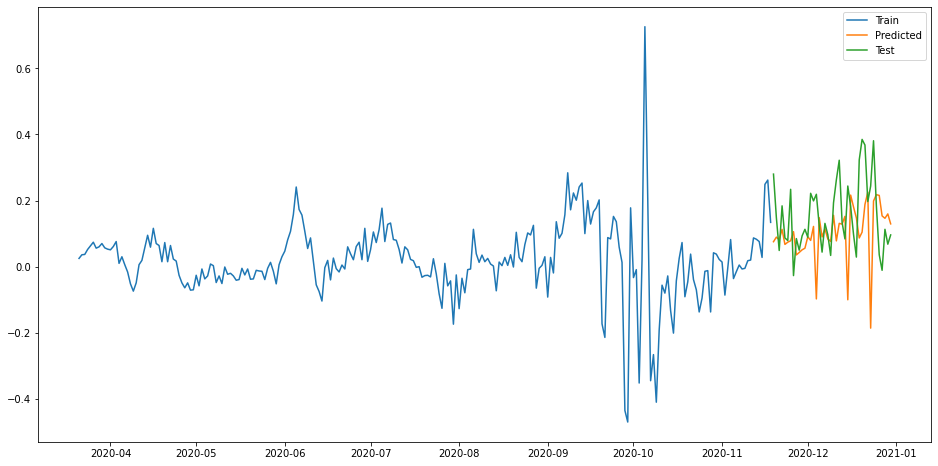

In [76]:
#Construct model Gradient Boosting
(best_score_gb_Chile, best_model_gb_Chile, 
 y_pred_gb_Chile) = model_construction_gb(Xtrain_Chile, Ytrain_Chile, Xtest_Chile)
regression_results(Ytest_Chile, y_pred_gb_Chile)

#Invert scalling
forecast_copies = np.repeat(np.array(y_pred_gb_Chile).reshape(Ytest_Chile.shape[0],1), df_ml_Chile.shape[1], axis = -1)
y_pred_gb_Chile_fut = scaler_df.inverse_transform(forecast_copies)[:,-1]

plot_ml(df_ml_Chile, Chile, y_pred_gb_Chile_fut)

No model presents a comparable performance on the Chile dataset. The 'r squared' value is negative across all models.

- **Tunisia**

In [77]:
def adjr2(actual, predict):
    r2 = metrics_ml.r2_score(actual, predict)
    n = Tunisia.shape[0]
    p = Tunisia.shape[1]
    adjr = 1-(1 - r2)*(n - 1)/(n - p - 1)
    return adjr

adjr2_score = make_scorer(adjr2, greater_is_better = False)

In [78]:
#Dataset diff
Tunisia = normalize_data_diff[normalize_data_diff['location'] == 'Tunisia']
Tunisia = Tunisia[['total_cases_per_million', 'new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 
                 'total_tests_per_thousand', 'positive_rate', 'stringency_index','new_tests_smoothed_per_thousand']] 

#transform dataset
df_ml_Tunisia = ml_transform_df(Tunisia)

#Scalling values
df_ml_val_Tunisia = df_ml_Tunisia.values
scaler_df = StandardScaler()
scaler_df = scaler_df.fit(df_ml_val_Tunisia)
df_scaled_Tunisia = scaler_df.transform(df_ml_val_Tunisia)

#Train Test split
(Xtrain_Tunisia, Ytrain_Tunisia, Xtest_Tunisia, Ytest_Tunisia) = train_test_split_df(df_scaled_Tunisia)

explained_variance:  0.0742
r2:  0.0364
adj r2:  -0.0047
MAE:  1.1999
MSE:  4.3853
RMSE:  2.0941


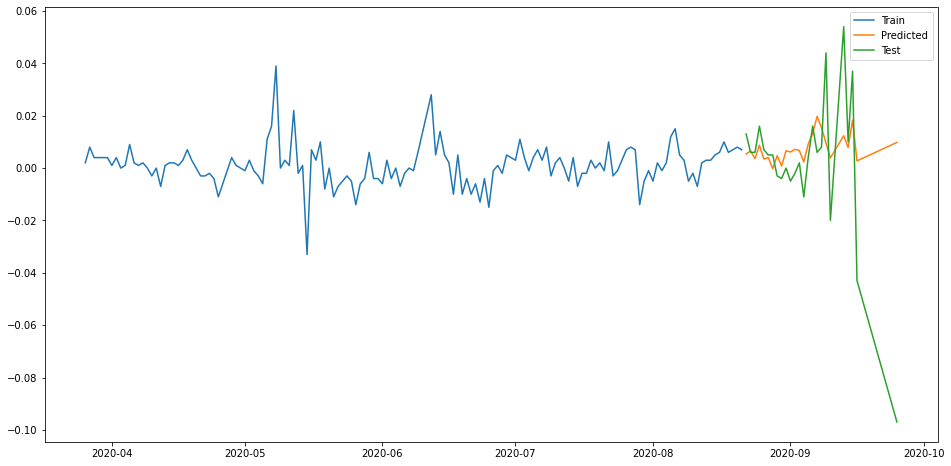

In [79]:
#Construct model Random Forest
(best_score_rf_Tunisia, best_model_rf_Tunisia, 
 y_pred_rf_Tunisia) = model_construction_rf(Xtrain_Tunisia, Ytrain_Tunisia, Xtest_Tunisia)
regression_results(Ytest_Tunisia, y_pred_rf_Tunisia)

#Invert scalling
forecast_copies = np.repeat(np.array(y_pred_rf_Tunisia).reshape(Ytest_Tunisia.shape[0],1), df_ml_Tunisia.shape[1], axis = -1)
y_pred_rf_Tunisia_fut = scaler_df.inverse_transform(forecast_copies)[:,-1]

plot_ml(df_ml_Tunisia, Tunisia, y_pred_rf_Tunisia_fut)

explained_variance:  0.0021
r2:  -0.0005
adj r2:  -0.0432
MAE:  1.2936
MSE:  4.5536
RMSE:  2.1339


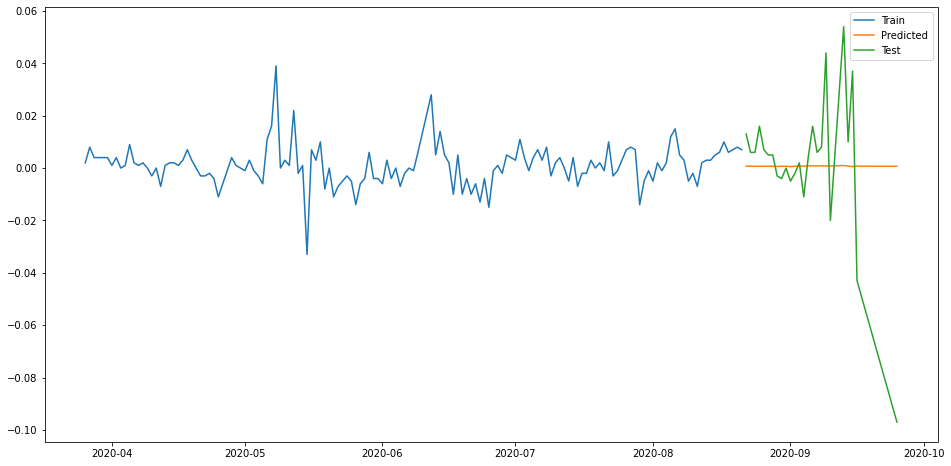

In [80]:
#Construct model Elastic Net
(best_score_en_Tunisia, best_model_en_Tunisia, 
 y_pred_en_Tunisia) = model_construction_en(Xtrain_Tunisia, Ytrain_Tunisia, Xtest_Tunisia)
regression_results(Ytest_Tunisia, y_pred_en_Tunisia)

#Invert scalling
forecast_copies = np.repeat(np.array(y_pred_en_Tunisia).reshape(Ytest_Tunisia.shape[0],1), df_ml_Tunisia.shape[1], axis = -1)
y_pred_en_Tunisia_fut = scaler_df.inverse_transform(forecast_copies)[:,-1]

plot_ml(df_ml_Tunisia, Tunisia, y_pred_en_Tunisia_fut)

explained_variance:  0.0181
r2:  -0.1242
adj r2:  -0.1721
MAE:  1.2769
MSE:  5.1162
RMSE:  2.2619


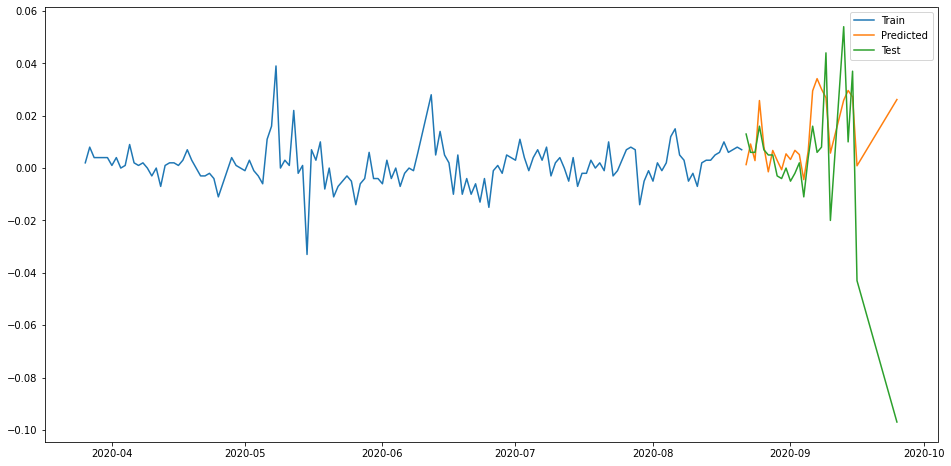

In [81]:
#Construct model Gradient Boosting
(best_score_gb_Tunisia, best_model_gb_Tunisia, 
 y_pred_gb_Tunisia) = model_construction_gb(Xtrain_Tunisia, Ytrain_Tunisia, Xtest_Tunisia)
regression_results(Ytest_Tunisia, y_pred_gb_Tunisia)

#Invert scalling
forecast_copies = np.repeat(np.array(y_pred_gb_Tunisia).reshape(Ytest_Tunisia.shape[0],1), df_ml_Tunisia.shape[1], axis = -1)
y_pred_gb_Tunisia_fut = scaler_df.inverse_transform(forecast_copies)[:,-1]

plot_ml(df_ml_Tunisia, Tunisia , y_pred_gb_Tunisia_fut)

No model presents a comparable performance on the Tunisia dataset. The 'r squared' value is negative in the Elastic Net and Gradient Boosting Regressor models.

---

#### 4.2.2. ARIMA Models

This represents another approach usually performed to predict a variable of a time series. 
The autoregressive integrated moving average (ARIMA).

In [85]:
def plot_arima(train, test,prediction):
    plt.figure(figsize=(16,8))
    plt.plot(train, label='training')
    plt.plot(test, label = 'test')
    plt.plot(prediction, label='predicted')
    plt.legend(loc='lower left')
    plt.show()
    

- **Australia**

In [86]:
Australia_diff = normalize_data_diff[normalize_data_diff['location'] == 'Australia']

In [87]:
new_df = pd.DataFrame(Australia_diff['new_tests_smoothed_per_thousand'])

In [88]:
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(new_df)

In [89]:
#check if non-stationary 
adf_test = ADFTest(alpha = 0.05)
adf_test.should_diff(scaled_data)

(0.01, False)

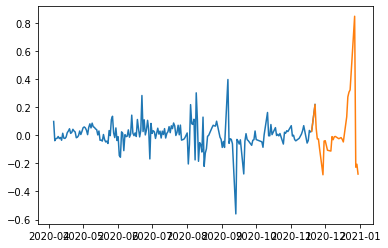

In [90]:
train = new_df[:200]
test = new_df[-27:]
plt.plot(train)
plt.plot(test)

In [91]:
arima_model = auto_arima(train, supress_warnings = True, stepwise = True)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  200
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 204.884
Date:                Thu, 21 Jan 2021   AIC                           -403.769
Time:                        21:39:12   BIC                           -393.874
Sample:                             0   HQIC                          -399.765
                                - 200                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7732      0.197      3.927      0.000       0.387       1.159
ma.L1         -0.6663      0.220     -3.034      0.002      -1.097      -0.236
sigma2         0.0075      0.000     25.516      0.000       0.007       0.008
===================================================================================
Ljung-Box (Q):                       54.59   Jarque-Bera (JB):              1120.90
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               4.74   Skew:                            -0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.50
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [92]:
prediction = pd.DataFrame(arima_model.predict(n_periods=27), index = test.index)
prediction.columns = ['new_tests_smoothed_per_thousand']

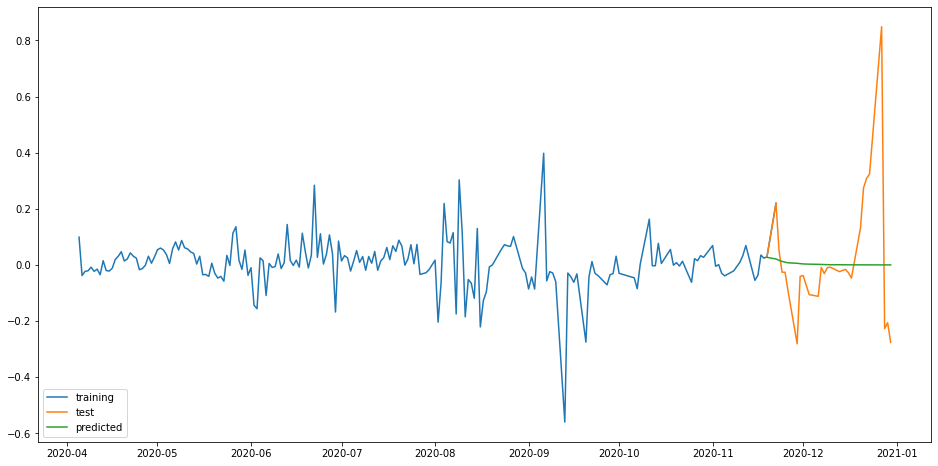

In [93]:
plot_arima(train, test,prediction)

In [94]:
test['predicted'] = prediction
r2 = r2_score(test['new_tests_smoothed_per_thousand'], test['predicted'])
mse = mean_squared_error(test['new_tests_smoothed_per_thousand'], test['predicted'])
print('mse: ', mse)
print('r2: ', r2)

mse:  0.05010942137433689
r2:  -0.006882183504756112


C:\Users\migue\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


The ARIMA model performs poorly on the Australia dataset, for the selected variable.

- **Luxembourg**

In [95]:
Luxembourg_diff = normalize_data_diff[normalize_data_diff['location'] == 'Luxembourg']
new_df2 = pd.DataFrame(Luxembourg_diff['new_tests_smoothed_per_thousand'])

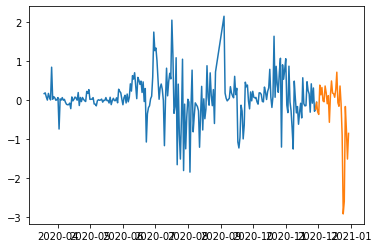

In [96]:
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(new_df2)


train = new_df2[:250]
test = new_df2[-32:]
plt.plot(train)
plt.plot(test)

In [97]:
arima_model = auto_arima(train, supress_warnings = True, stepwise = True)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  250
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -189.253
Date:                Thu, 21 Jan 2021   AIC                            384.506
Time:                        21:39:14   BIC                            395.070
Sample:                             0   HQIC                           388.758
                                - 250                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8196      0.070     11.719      0.000       0.682       0.957
ma.L1         -0.6326      0.094     -6.759      0.000      -0.816      -0.449
sigma2         0.2659      0.014     18.627      0.000       0.238       0.294
===================================================================================
Ljung-Box (Q):                      133.65   Jarque-Bera (JB):               139.42
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               9.42   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [98]:
prediction = pd.DataFrame(arima_model.predict(n_periods=32), index = test.index)
prediction.columns = ['new_tests_smoothed_per_thousand']

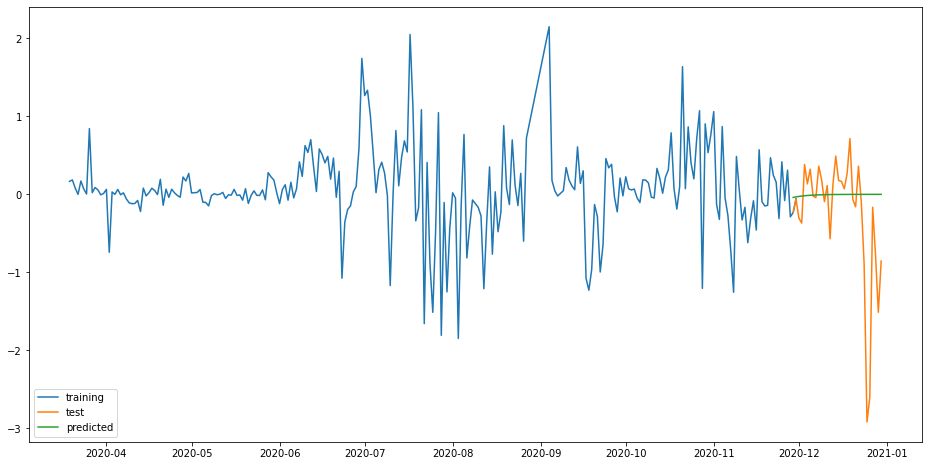

In [99]:
plot_arima(train, test,prediction)

In [100]:
test['predicted'] = prediction
r2 = r2_score(test['new_tests_smoothed_per_thousand'], test['predicted'])
mse = mean_squared_error(test['new_tests_smoothed_per_thousand'], test['predicted'])
print('mse: ', mse)
print('r2: ', r2)

mse:  0.6830049131709567
r2:  -0.0957834885312252


C:\Users\migue\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


The ARIMA model performs poorly on the Luxembourg dataset, for the selected variable.

- **Israel**

In [101]:
Israel = normalize_data[normalize_data['location'] == 'Israel']
Israel_diff = normalize_data_diff[normalize_data_diff['location'] == 'Israel']
new_df3 = pd.DataFrame(Israel_diff['new_tests_smoothed_per_thousand'])

In [102]:
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(new_df3)

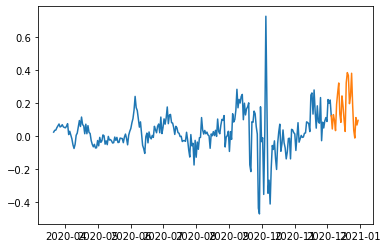

In [103]:
train = new_df3[:260]
test = new_df3[-26:]
plt.plot(train)
plt.plot(test)

In [104]:
arima_model = auto_arima(train, supress_warnings = True, stepwise = True)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  260
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 238.292
Date:                Thu, 21 Jan 2021   AIC                           -468.584
Time:                        21:39:18   BIC                           -454.341
Sample:                             0   HQIC                          -462.858
                                - 260                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9276      0.044     20.952      0.000       0.841       1.014
ma.L1         -0.3547      0.057     -6.216      0.000      -0.467      -0.243
ma.L2         -0.3711      0.036    -10.253      0.000      -0.442      -0.300
sigma2         0.0093      0.000     21.660      0.000       0.008       0.010
===================================================================================
Ljung-Box (Q):                       59.88   Jarque-Bera (JB):              1472.84
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):              12.45   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [105]:
prediction = pd.DataFrame(arima_model.predict(n_periods=26), index = test.index)
prediction.columns = ['new_tests_smoothed_per_thousand']

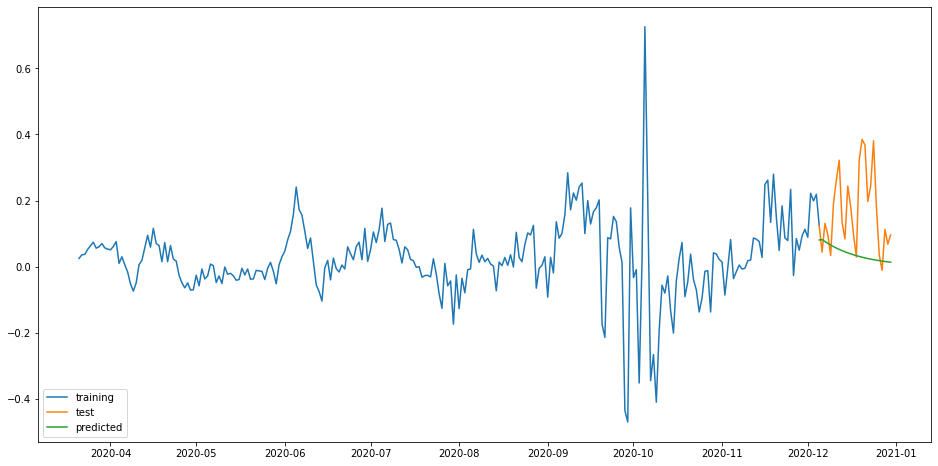

In [106]:
plot_arima(train, test,prediction)

In [107]:
test['predicted'] = prediction
r2 = r2_score(test['new_tests_smoothed_per_thousand'], test['predicted'])
mse = mean_squared_error(test['new_tests_smoothed_per_thousand'], test['predicted'])
print('mse: ', mse)
print('r2: ', r2)

mse:  0.030744212831910298
r2:  -1.3204658770109545


C:\Users\migue\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


The ARIMA model performs poorly on the Israel dataset, for the selected variable.

- **Tunisia**

In [108]:
Tunisia = normalize_data[normalize_data['location'] == 'Tunisia']
Tunisia_diff = normalize_data_diff[normalize_data_diff['location'] == 'Tunisia']
new_df5 = pd.DataFrame(Tunisia_diff['new_tests_smoothed_per_thousand'])

In [109]:
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(new_df5)

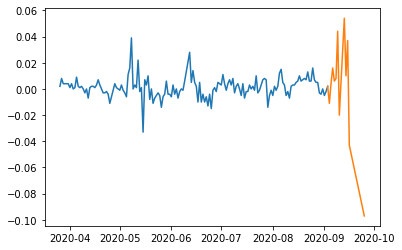

In [110]:
train = new_df5[:160]
test = new_df5[-13:]
plt.plot(train)
plt.plot(test)

In [111]:
arima_model = auto_arima(train, supress_warnings = True, stepwise = True)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  160
Model:               SARIMAX(2, 0, 5)   Log Likelihood                 582.911
Date:                Thu, 21 Jan 2021   AIC                          -1149.822
Time:                        21:39:26   BIC                          -1125.221
Sample:                             0   HQIC                         -1139.832
                                - 160                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1749      0.936     -0.187      0.852      -2.009       1.660
ar.L2          0.5995      0.838      0.716      0.474      -1.042       2.241
ma.L1          0.7003      0.941      0.745      0.457      -1.143       2.544
ma.L2         -0.3109      1.332     -0.233      0.815      -2.922       2.301
ma.L3         -0.2669      0.600     -0.444      0.657      -1.444       0.910
ma.L4          0.0533      0.147      0.362      0.718      -0.236       0.342
ma.L5         -0.2141      0.182     -1.178      0.239      -0.571       0.142
sigma2      3.982e-05   3.45e-06     11.541      0.000    3.31e-05    4.66e-05
===================================================================================
Ljung-Box (Q):                       46.74   Jarque-Bera (JB):                86.56
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               0.51   Skew:                             0.60
Prob(H) (two-sided):                  0.02   Kurtosis:                         6.40
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [112]:
prediction = pd.DataFrame(arima_model.predict(n_periods=13), index = test.index)
prediction.columns = ['new_tests_smoothed_per_thousand']

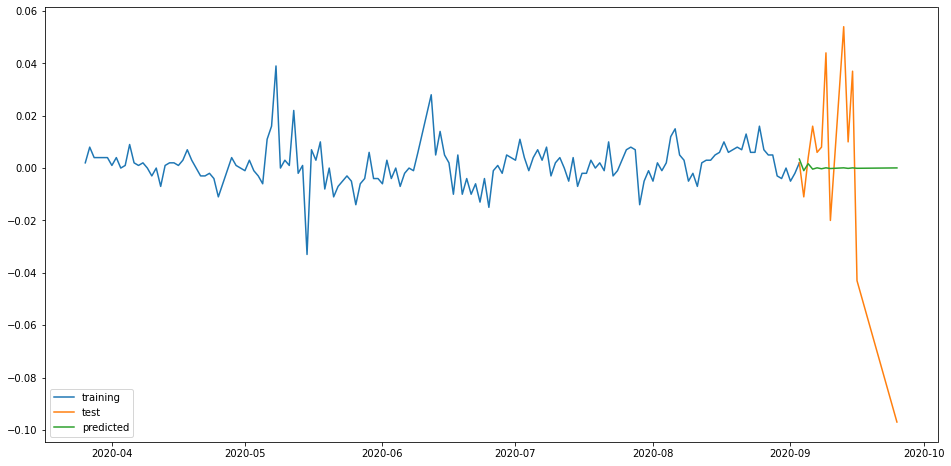

In [113]:
plot_arima(train, test,prediction)

In [114]:
test['predicted'] = prediction
r2 = r2_score(test['new_tests_smoothed_per_thousand'], test['predicted'])
mse = mean_squared_error(test['new_tests_smoothed_per_thousand'], test['predicted'])
print('mse: ', mse)
print('r2: ', r2)

mse:  0.001418068361127735
r2:  0.0018095322107427592


C:\Users\migue\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


The ARIMA model performs poorly on the Tunisia dataset, for the selected variable, with an 'r squared' value very close to zero.

- **Chile**

In [115]:
chile = normalize_data[normalize_data['location'] == 'Chile']
chile_diff = normalize_data_diff[normalize_data_diff['location'] == 'Chile']
new_df6 = pd.DataFrame(chile_diff['new_tests_smoothed_per_thousand'])

In [116]:
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(new_df6)

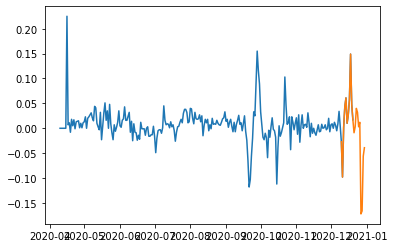

In [117]:
train = new_df6[:255]
test = new_df6[-21:]
plt.plot(train)
plt.plot(test)

In [118]:
arima_model = auto_arima(train, supress_warnings = True, stepwise = True)
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  255
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 549.651
Date:                Thu, 21 Jan 2021   AIC                          -1089.303
Time:                        21:39:29   BIC                          -1071.596
Sample:                             0   HQIC                         -1082.181
                                - 255                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0076      0.004      1.996      0.046       0.000       0.015
ar.L1         -0.4043      0.150     -2.692      0.007      -0.699      -0.110
ar.L2          0.4855      0.068      7.179      0.000       0.353       0.618
ma.L1          0.8604      0.160      5.374      0.000       0.547       1.174
sigma2         0.0008   2.95e-05     26.558      0.000       0.001       0.001
===================================================================================
Ljung-Box (Q):                       48.81   Jarque-Bera (JB):              3352.06
Prob(Q):                              0.16   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             1.88
Prob(H) (two-sided):                  0.50   Kurtosis:                        20.36
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [119]:
prediction = pd.DataFrame(arima_model.predict(n_periods=21), index = test.index)
prediction.columns = ['new_tests_smoothed_per_thousand']

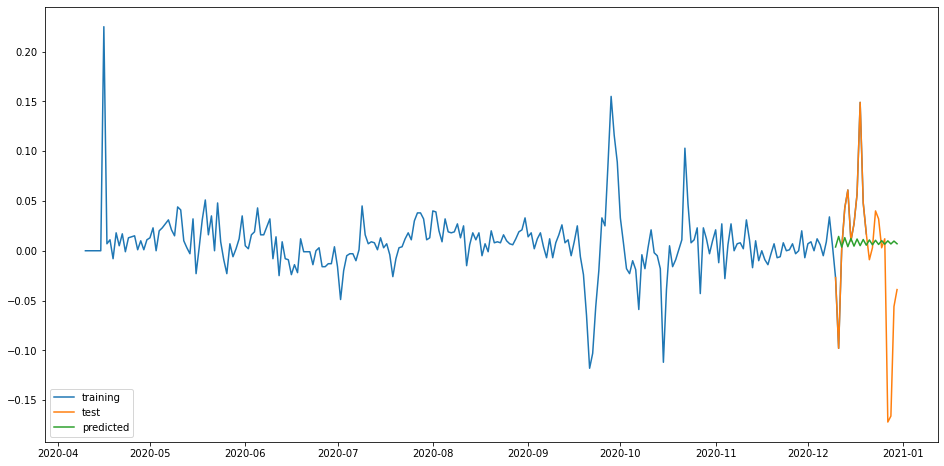

In [120]:
plot_arima(train, test,prediction)

In [121]:
test['predicted'] = prediction
r2 = r2_score(test['new_tests_smoothed_per_thousand'], test['predicted'])
mse = mean_squared_error(test['new_tests_smoothed_per_thousand'], test['predicted'])
print('mse: ', mse)
print('r2: ', r2)

mse:  0.0054215664981599136
r2:  -0.04209362093248803


C:\Users\migue\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


The ARIMA model performs poorly on the Chile dataset, for the selected variable.

All ML models attempted for the prediction of the variable 'new_tests_smoothed_per_thousand' in all the countries selected performed extremely poorly. Most of the times, the 'r squared' metric was negative or very low. This could be due to a lack of entries in the datasets.

<!-- The ARIMA model performs poorly on the Chile dataset, for the selected variable. -->

## 5. Deep Learning

### 5.1. Construction of the models

According to literature, we can apply DL models to both stationary and non-stationary time series. We performed the same DL analysis with both approaches but got far better results for non-stationary time series. We present below only the approach with a non-stationary time series.

#### 5.1.1. Univariate analysis

This analysis will allow for plotting the predictions of the model for a determined number of days and the corresponding real values for those dates. We will also try to predict the value for the next day (day after all the data).

- **Australia**

In [226]:
Australia = normalize_data[normalize_data['location'] == 'Australia']

In [227]:
data = Australia.filter(['new_tests_smoothed_per_thousand'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .85)

In [228]:
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(dataset)

In [229]:
train_data =scaled_data[0:training_data_len,:]
x_train =[]
y_train = []

for i in range (60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

In [230]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [231]:
#reshape the data for lstm
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1) )
x_train.shape

(133, 60, 1)

In [232]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

In [233]:
#compile the model
model.compile(optimizer = 'adam', loss='mean_squared_error')

In [234]:
history = model.fit(x_train, y_train, batch_size = 10, validation_split=0.1, epochs = 20)

Epoch 1/20
12/12 [==============================] - 3s 78ms/step - loss: 0.2589 - val_loss: 0.0161
Epoch 2/20
12/12 [==============================] - 0s 31ms/step - loss: 0.0272 - val_loss: 7.0514e-04
Epoch 3/20
12/12 [==============================] - 0s 29ms/step - loss: 0.0150 - val_loss: 0.0031
Epoch 4/20
12/12 [==============================] - 0s 30ms/step - loss: 0.0144 - val_loss: 7.3807e-04
Epoch 5/20
12/12 [==============================] - 0s 31ms/step - loss: 0.0115 - val_loss: 4.9542e-04
Epoch 6/20
12/12 [==============================] - 0s 34ms/step - loss: 0.0105 - val_loss: 0.0015
Epoch 7/20
12/12 [==============================] - 0s 31ms/step - loss: 0.0106 - val_loss: 4.9887e-04
Epoch 8/20
12/12 [==============================] - 0s 32ms/step - loss: 0.0097 - val_loss: 0.0014
Epoch 9/20
12/12 [==============================] - 0s 33ms/step - loss: 0.0104 - val_loss: 0.0010
Epoch 10/20
12/12 [==============================] - 0s 32ms/step - loss: 0.0095 - val_loss: 

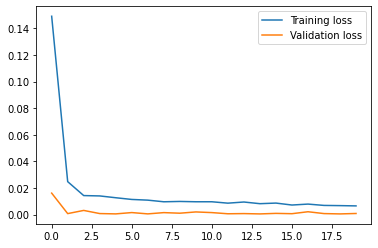

In [235]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

The model appears to have good values for 'loss'. Doesn't seem to be occurring overfitting or underfitting events.

In [236]:
#create the testing dataset
#create a new array with scale values
test_data = scaled_data[training_data_len - 60:, :]
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range (60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

In [237]:
#convert to numpy array
x_test = np.array(x_test)

In [238]:
#reshape
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [239]:
#get predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [240]:
#evaluate the model
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.052793872457562084

C:\Users\migue\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


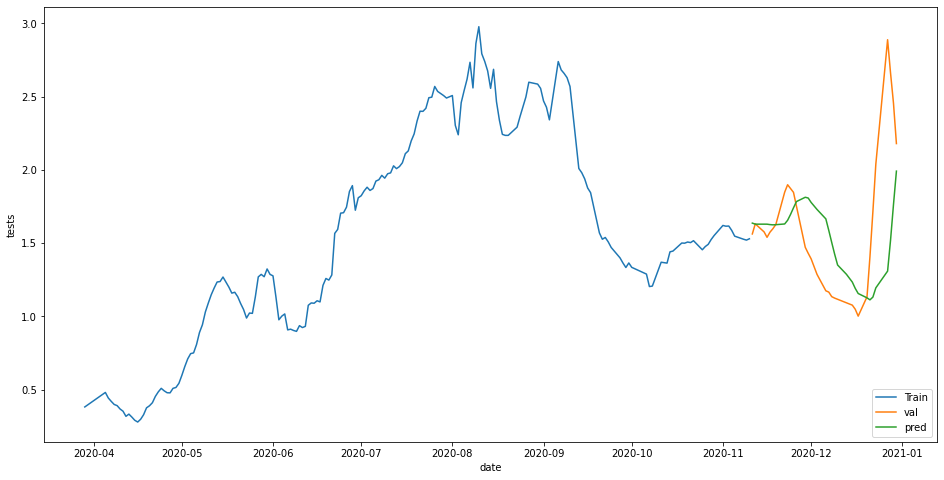

In [241]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions']=predictions

plt.figure(figsize=(16,8))
plt.xlabel('date')
plt.ylabel('tests')
plt.plot(train['new_tests_smoothed_per_thousand'])
plt.plot(valid[['new_tests_smoothed_per_thousand','predictions']])
plt.legend(['Train', 'val', 'pred'], loc = 'lower right')
plt.show()

In this plot we can observe the real values in the validation set and the predicted values for the same corresponding dates.

In [243]:
new_df = Australia.filter(['new_tests_smoothed_per_thousand'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test=[]
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
pred_tests = model.predict(X_test)
pred_tests = scaler.inverse_transform(pred_tests)
print('The preciction for the next day is: ',pred_tests.item() , 'new tests smoothed per thousand habitants')

The preciction for the next day is:  2.1683521270751953 new tests smoothed per thousand habitants


- **Luxembourg**

In [261]:
Luxembourg = normalize_data[normalize_data['location'] == 'Luxembourg']
data = Luxembourg.filter(['new_tests_smoothed_per_thousand'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .85)

In [262]:
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(dataset)

In [263]:
train_data =scaled_data[0:training_data_len,:]
x_train =[]
y_train = []
for i in range (60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
#reshape the data for lstm
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1) )

In [264]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))
#compile and train the model
model.compile(optimizer = 'adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, batch_size = 10, validation_split = 0.1, epochs = 20)

Epoch 1/20
17/17 [==============================] - 3s 61ms/step - loss: 0.1260 - val_loss: 0.0522
Epoch 2/20
17/17 [==============================] - 1s 32ms/step - loss: 0.0212 - val_loss: 0.0092
Epoch 3/20
17/17 [==============================] - 1s 30ms/step - loss: 0.0147 - val_loss: 0.0206
Epoch 4/20
17/17 [==============================] - 1s 31ms/step - loss: 0.0101 - val_loss: 0.0127
Epoch 5/20
17/17 [==============================] - 1s 45ms/step - loss: 0.0117 - val_loss: 0.0057
Epoch 6/20
17/17 [==============================] - 1s 41ms/step - loss: 0.0088 - val_loss: 0.0045
Epoch 7/20
17/17 [==============================] - 1s 31ms/step - loss: 0.0075 - val_loss: 0.0069
Epoch 8/20
17/17 [==============================] - 1s 31ms/step - loss: 0.0068 - val_loss: 0.0046
Epoch 9/20
17/17 [==============================] - 1s 30ms/step - loss: 0.0053 - val_loss: 0.0028
Epoch 10/20
17/17 [==============================] - 1s 30ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 11/

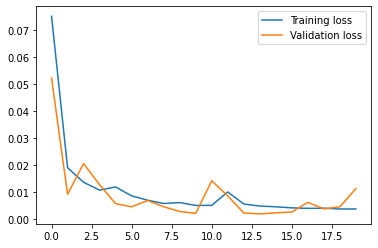

In [265]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

The model appears to have good values for ' training loss', but the 'validation loss' presents some irregular behaviour with a decreasing tendency.

In [266]:
#create the testing dataset
#create a new array with scale values
test_data = scaled_data[training_data_len - 60:, :]
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range (60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

#convert to numpy array
x_test = np.array(x_test)
#reshape
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [267]:
#get predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
#evaluate the model
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

1.8920495770772299

C:\Users\migue\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


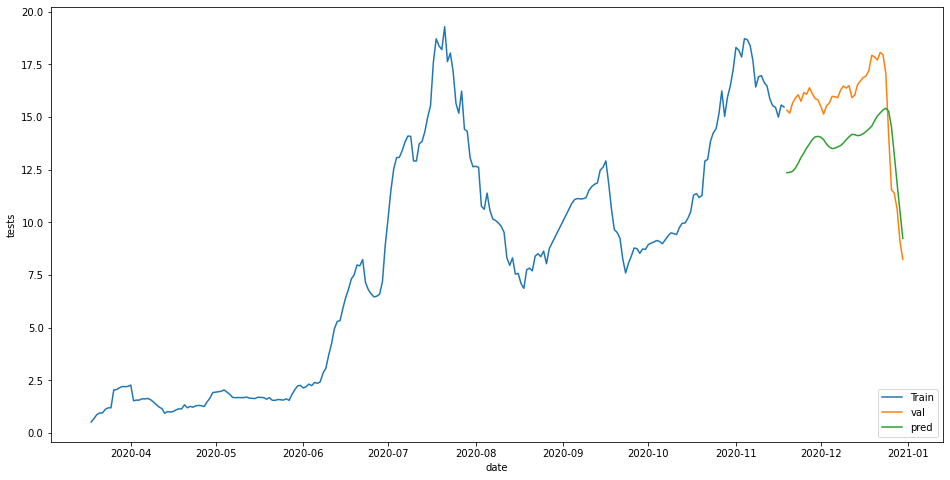

In [268]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions']=predictions

plt.figure(figsize=(16,8))
plt.xlabel('date')
plt.ylabel('tests')
plt.plot(train['new_tests_smoothed_per_thousand'])
plt.plot(valid[['new_tests_smoothed_per_thousand','predictions']])
plt.legend(['Train', 'val', 'pred'], loc = 'lower right')
plt.show()

In [269]:
new_df = Luxembourg.filter(['new_tests_smoothed_per_thousand'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test=[]
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
pred_tests = model.predict(X_test)
pred_tests = scaler.inverse_transform(pred_tests)
print('The preciction for the next day is: ',pred_tests.item() , 'new tests smoothed per thousand habitants')

The preciction for the next day is:  8.07272720336914 new tests smoothed per thousand habitants


- **Israel**

In [270]:
Israel = normalize_data[normalize_data['location'] == 'Israel']
data = Israel.filter(['new_tests_smoothed_per_thousand'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .85)

In [271]:
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(dataset)
train_data =scaled_data[0:training_data_len,:]
x_train =[]
y_train = []

for i in range (60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
#reshape the data for lstm
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1) )
# x_train.shape

In [272]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))
#compile the model
model.compile(optimizer = 'adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, batch_size = 10, validation_split = 0.1, epochs = 20)

Epoch 1/20
17/17 [==============================] - 3s 64ms/step - loss: 0.0333 - val_loss: 0.0059
Epoch 2/20
17/17 [==============================] - 1s 32ms/step - loss: 0.0049 - val_loss: 6.8556e-04
Epoch 3/20
17/17 [==============================] - 1s 37ms/step - loss: 0.0021 - val_loss: 9.9618e-04
Epoch 4/20
17/17 [==============================] - 1s 46ms/step - loss: 0.0021 - val_loss: 6.1880e-04
Epoch 5/20
17/17 [==============================] - 1s 30ms/step - loss: 0.0016 - val_loss: 5.4427e-04
Epoch 6/20
17/17 [==============================] - 1s 31ms/step - loss: 0.0014 - val_loss: 6.7097e-04
Epoch 7/20
17/17 [==============================] - 0s 29ms/step - loss: 0.0014 - val_loss: 5.1717e-04
Epoch 8/20
17/17 [==============================] - 1s 32ms/step - loss: 0.0012 - val_loss: 7.2198e-04
Epoch 9/20
17/17 [==============================] - 1s 31ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 10/20
17/17 [==============================] - ETA: 0s - loss: 0.001 - 1s 3

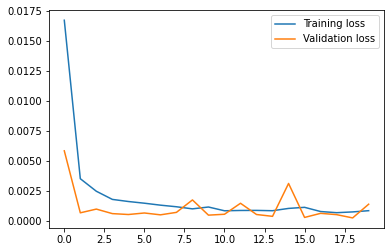

In [273]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

The model appears to have good values for ' training loss', but the 'validation loss' presents some irregular behaviour with a decreasing tendency.

In [274]:
#create the testing dataset
#create a new array with scale values
test_data = scaled_data[training_data_len - 60:, :]
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range (60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

#convert to numpy array
x_test = np.array(x_test)
#reshape
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
#get predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
#evaluate the model
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

1.1262910386494227

C:\Users\migue\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


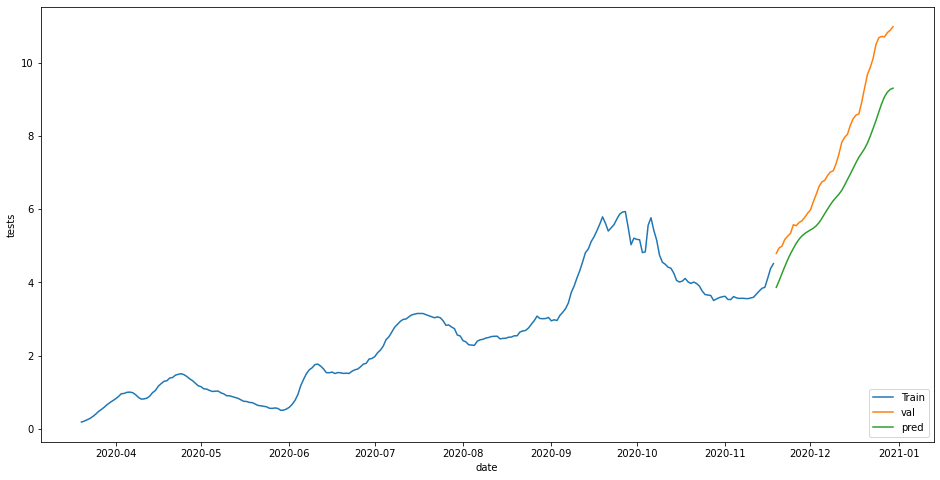

In [276]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions']=predictions

plt.figure(figsize=(16,8))
plt.xlabel('date')
plt.ylabel('tests')
plt.plot(train['new_tests_smoothed_per_thousand'])
plt.plot(valid[['new_tests_smoothed_per_thousand','predictions']])
plt.legend(['Train', 'val', 'pred'], loc = 'lower right')
plt.show()

In [277]:
new_df = Israel.filter(['new_tests_smoothed_per_thousand'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test=[]
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
pred_tests = model.predict(X_test)
pred_tests = scaler.inverse_transform(pred_tests)
print('The preciction for the next day is: ',pred_tests.item() , 'new tests smoothed per thousand habitants')

The preciction for the next day is:  9.301761627197266 new tests smoothed per thousand habitants


- **Tunisia**

In [278]:
Tunisia = normalize_data[normalize_data['location'] == 'Tunisia']
data = Tunisia.filter(['new_tests_smoothed_per_thousand'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .85)

In [279]:
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(dataset)


train_data =scaled_data[0:training_data_len,:]
x_train =[]
y_train = []

for i in range (60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
#reshape the data for lstm
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1) )

In [284]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

#compile the model
model.compile(optimizer = 'adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, batch_size = 5, validation_split = 0.1, epochs = 40)

Epoch 1/40
16/16 [==============================] - 3s 63ms/step - loss: 0.0128 - val_loss: 0.0321
Epoch 2/40
16/16 [==============================] - 0s 29ms/step - loss: 0.0051 - val_loss: 0.0276
Epoch 3/40
16/16 [==============================] - 1s 33ms/step - loss: 0.0041 - val_loss: 0.0225
Epoch 4/40
16/16 [==============================] - 1s 54ms/step - loss: 0.0029 - val_loss: 0.0215
Epoch 5/40
16/16 [==============================] - 1s 42ms/step - loss: 0.0034 - val_loss: 0.0213
Epoch 6/40
16/16 [==============================] - 1s 36ms/step - loss: 0.0025 - val_loss: 0.0223
Epoch 7/40
16/16 [==============================] - 1s 33ms/step - loss: 0.0026 - val_loss: 0.0082
Epoch 8/40
16/16 [==============================] - 0s 32ms/step - loss: 0.0024 - val_loss: 0.0182
Epoch 9/40
16/16 [==============================] - 0s 31ms/step - loss: 0.0024 - val_loss: 0.0134
Epoch 10/40
16/16 [==============================] - 0s 31ms/step - loss: 0.0018 - val_loss: 0.0100
Epoch 11/

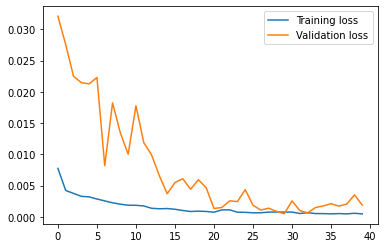

In [285]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

The model appears to have good values for 'training loss', but the 'validation loss' presents some irregular behaviour with a decreasing tendency.

In [286]:
#create the testing dataset
#create a new array with scale values
test_data = scaled_data[training_data_len - 60:, :]
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range (60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

#convert to numpy array
x_test = np.array(x_test)
#reshape
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
#get predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
#evaluate the model
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.018996671528816223

C:\Users\migue\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


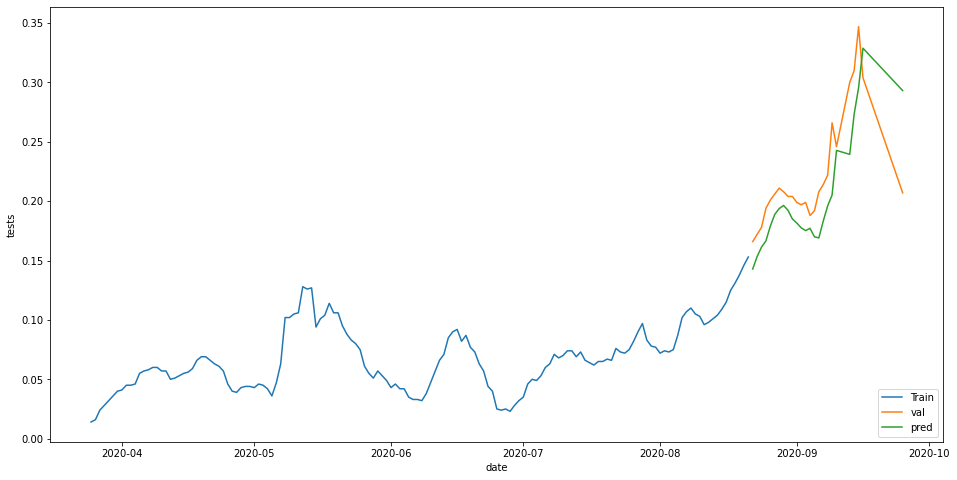

In [287]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions']=predictions

plt.figure(figsize=(16,8))
plt.xlabel('date')
plt.ylabel('tests')
plt.plot(train['new_tests_smoothed_per_thousand'])
plt.plot(valid[['new_tests_smoothed_per_thousand','predictions']])
plt.legend(['Train', 'val', 'pred'], loc = 'lower right')
plt.show()

In [288]:
new_df = Tunisia.filter(['new_tests_smoothed_per_thousand'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test=[]
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
pred_tests = model.predict(X_test)
pred_tests = scaler.inverse_transform(pred_tests)
print('The preciction for the next day is: ',pred_tests.item() , 'new tests smoothed per thousand habitants')

The preciction for the next day is:  0.17767971754074097 new tests smoothed per thousand habitants


- **Chile**

In [289]:
chile = normalize_data[normalize_data['location'] == 'Chile']
data = chile.filter(['new_tests_smoothed_per_thousand'])
dataset = data.values
training_data_len = math.ceil(len(dataset) * .85)

In [290]:
scaler = MinMaxScaler(feature_range =(0,1))
scaled_data = scaler.fit_transform(dataset)


train_data =scaled_data[0:training_data_len,:]
x_train =[]
y_train = []

for i in range (60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
#reshape the data for lstm
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1) )

In [291]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))

#compile the model
model.compile(optimizer = 'adam', loss='mean_squared_error')
history = model.fit(x_train, y_train, batch_size = 10, validation_split = 0.1, epochs = 20)

Epoch 1/20
15/15 [==============================] - 3s 61ms/step - loss: 0.1803 - val_loss: 0.0224
Epoch 2/20
15/15 [==============================] - 0s 26ms/step - loss: 0.0133 - val_loss: 6.3957e-04
Epoch 3/20
15/15 [==============================] - 0s 24ms/step - loss: 0.0040 - val_loss: 0.0066
Epoch 4/20
15/15 [==============================] - 0s 24ms/step - loss: 0.0038 - val_loss: 7.5986e-04
Epoch 5/20
15/15 [==============================] - 0s 25ms/step - loss: 0.0033 - val_loss: 6.4043e-04
Epoch 6/20
15/15 [==============================] - 0s 24ms/step - loss: 0.0026 - val_loss: 5.5466e-04
Epoch 7/20
15/15 [==============================] - 0s 25ms/step - loss: 0.0026 - val_loss: 2.5242e-04
Epoch 8/20
15/15 [==============================] - 0s 25ms/step - loss: 0.0025 - val_loss: 0.0022
Epoch 9/20
15/15 [==============================] - 0s 24ms/step - loss: 0.0030 - val_loss: 8.5425e-04
Epoch 10/20
15/15 [==============================] - 0s 31ms/step - loss: 0.0022 - va

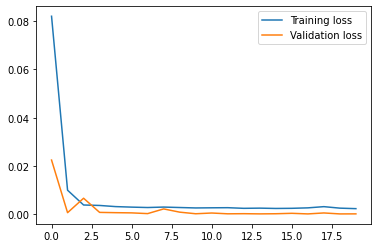

In [292]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

The model appears to have good values for the 'loss' metrics.

In [293]:
#create the testing dataset
#create a new array with scale values
test_data = scaled_data[training_data_len - 60:, :]
x_test=[]
y_test=dataset[training_data_len:,:]
for i in range (60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

#convert to numpy array
x_test = np.array(x_test)
#reshape
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
#get predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
#evaluate the model
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.030770583641834708

C:\Users\migue\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


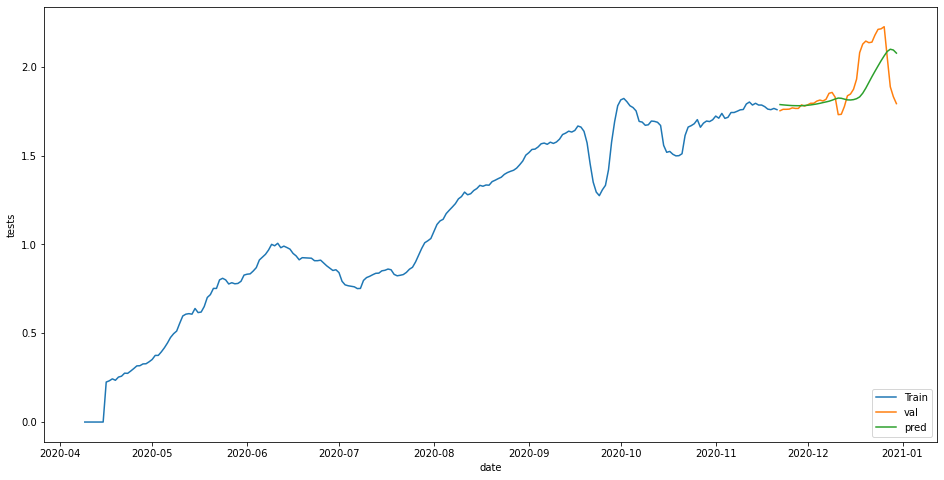

In [294]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['predictions']=predictions

plt.figure(figsize=(16,8))
plt.xlabel('date')
plt.ylabel('tests')
plt.plot(train['new_tests_smoothed_per_thousand'])
plt.plot(valid[['new_tests_smoothed_per_thousand','predictions']])
plt.legend(['Train', 'val', 'pred'], loc = 'lower right')
plt.show()

In [295]:
new_df = chile.filter(['new_tests_smoothed_per_thousand'])
last_60_days = new_df[-60:].values
last_60_days_scaled = scaler.transform(last_60_days)
X_test=[]
X_test.append(last_60_days_scaled)
X_test = np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0], X_test.shape[1], 1))
pred_tests = model.predict(X_test)
pred_tests = scaler.inverse_transform(pred_tests)
print('The preciction for the next day is: ',pred_tests.item() , 'new tests smoothed per thousand habitants')

The preciction for the next day is:  2.049992322921753 new tests smoothed per thousand habitants


#### 5.1.2. Multivariated analysis

On this occasion we want to give the model more variables from the dataset.

We also need to apply the sliding window method.

The data given to the model includes the values of n days before the instance t.
This means that, for each value of the variable 'new_test_smoothed_per_thousand', a dataset matrix is organized with the values of the n number of entries previous to the entry t.

We will have (total number of entries - n) matrices, each used to predict the correspondent value of 'new_test_smoothed_per_thousand' t, with the shape (n entries, number of features of the original dataset):
                                                                               
    feature 1, ....., ntst(t-n)
    feature 1, ....., ntst(t-n-1)
    feature 1, ....., ntst(t-n-2)
    :
    :
    feature 1, ....., ntst(t-n-(n+1))
    
shape - ( (total number of entries - n), n, number of features of the original dataset )

- **Australia**

In [296]:
Australia = normalize_data[normalize_data['location'] == 'Australia']

Australia = Australia[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
                       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients_per_million', 
                       'hosp_patients_per_million', 'weekly_icu_admissions_per_million', 
                       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand', 
                       'positive_rate', 'tests_per_case', 'stringency_index', 'population_density', 'median_age', 
                       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 
                       'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index',
                       'new_tests_smoothed_per_thousand']] 

In [297]:
scaler = StandardScaler()
australia = Australia.values
scaler = scaler.fit(australia)
df_for_training_scaled = scaler.transform(australia)

In [298]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to predict into the future
n_past = 7     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:australia.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, -1])

trainX, trainY = np.array(trainX), np.array(trainY)

index_split = math.ceil(trainX.shape[0]  * .15)

testX = trainX[-index_split:]
testY = trainY[-index_split:]

trainX = trainX[:-index_split]
trainY = trainY[:-index_split]

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (186, 7, 23).
trainY shape == (186, 1).


In [299]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_42 (LSTM)               (None, 7, 64)             22528     
_________________________________________________________________
lstm_43 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 33        
Total params: 34,977
Trainable params: 34,977
Non-trainable params: 0
_________________________________________________________________


In [300]:
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
11/11 [==============================] - 2s 35ms/step - loss: 1.0095 - val_loss: 0.0072
Epoch 2/10
11/11 [==============================] - 0s 10ms/step - loss: 0.4047 - val_loss: 0.0224
Epoch 3/10
11/11 [==============================] - 0s 8ms/step - loss: 0.1408 - val_loss: 0.0442
Epoch 4/10
11/11 [==============================] - 0s 48ms/step - loss: 0.1187 - val_loss: 0.0599
Epoch 5/10
11/11 [==============================] - 0s 10ms/step - loss: 0.1005 - val_loss: 0.0397
Epoch 6/10
11/11 [==============================] - 0s 11ms/step - loss: 0.1040 - val_loss: 0.0582
Epoch 7/10
11/11 [==============================] - 0s 8ms/step - loss: 0.0722 - val_loss: 0.0535
Epoch 8/10
11/11 [==============================] - 0s 9ms/step - loss: 0.0938 - val_loss: 0.0530
Epoch 9/10
11/11 [==============================] - 0s 10ms/step - loss: 0.0536 - val_loss: 0.0422
Epoch 10/10
11/11 [==============================] - 0s 11ms/step - loss: 0.0585 - val_loss: 0.0317


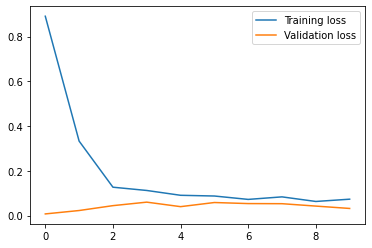

In [301]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [302]:
forecast_period_dates = Australia.index[-index_split:]

forecast = model.predict(testX) #forecast 

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, australia.shape[1], axis = -1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,-1]


# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'new_tests_smoothed_per_thousand':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])


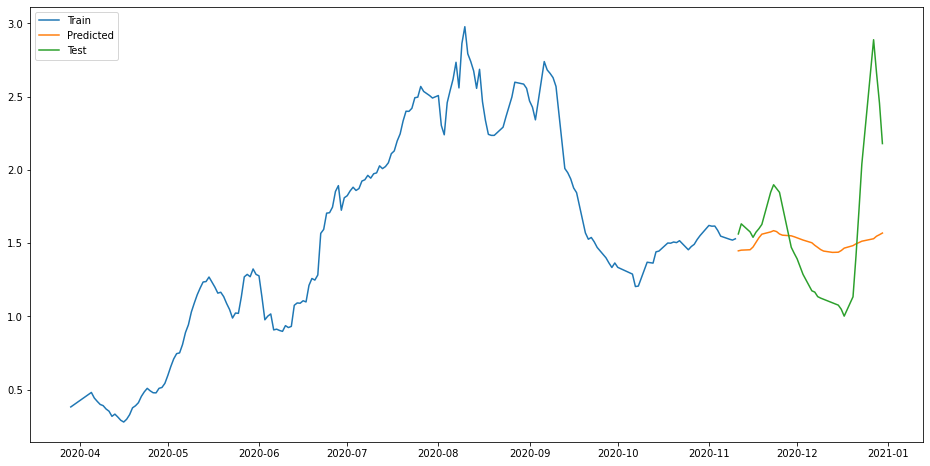

In [305]:
plt.figure(figsize=(16,8))
plt.plot(Australia.index[:-index_split], Australia['new_tests_smoothed_per_thousand'][:-index_split], label = 'Train')
plt.plot(df_forecast['date'][-index_split:], df_forecast['new_tests_smoothed_per_thousand'][-index_split:], label = 'Predicted')
plt.plot(Australia.index[-index_split:], Australia['new_tests_smoothed_per_thousand'][-index_split:], label = 'Test')
plt.legend()

As we can observe on the plot above the model can't predict correctly the tendency of the variable 'new_tests_smoothed_per_thousand'.

- **Luxembourg**

In [306]:
Luxembourg = normalize_data[normalize_data['location'] == 'Luxembourg']

Luxembourg = Luxembourg[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
                       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients_per_million', 
                       'hosp_patients_per_million', 'weekly_icu_admissions_per_million', 
                       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand', 
                       'positive_rate', 'tests_per_case', 'stringency_index', 'population_density', 'median_age', 
                       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 
                       'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index',
                       'new_tests_smoothed_per_thousand']]

In [307]:
scaler = StandardScaler()
luxembourg = Luxembourg.values
scaler = scaler.fit(luxembourg)
df_for_training_scaled = scaler.transform(luxembourg)

In [308]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to predict into the future
n_past = 7     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:luxembourg.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, -1])

trainX, trainY = np.array(trainX), np.array(trainY)

index_split = math.ceil(trainX.shape[0]  * .15)

testX = trainX[-index_split:]
testY = trainY[-index_split:]

trainX = trainX[:-index_split]
trainY = trainY[:-index_split]

In [309]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_44 (LSTM)               (None, 7, 64)             22528     
_________________________________________________________________
lstm_45 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_6 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 33        
Total params: 34,977
Trainable params: 34,977
Non-trainable params: 0
_________________________________________________________________


In [326]:
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
13/13 [==============================] - 0s 11ms/step - loss: 0.0212 - val_loss: 0.0546
Epoch 2/10
13/13 [==============================] - 0s 9ms/step - loss: 0.0256 - val_loss: 0.0426
Epoch 3/10
13/13 [==============================] - 0s 8ms/step - loss: 0.0252 - val_loss: 0.0403
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 0.0148 - val_loss: 0.0325
Epoch 5/10
13/13 [==============================] - 0s 7ms/step - loss: 0.0167 - val_loss: 0.0372
Epoch 6/10
13/13 [==============================] - 0s 7ms/step - loss: 0.0225 - val_loss: 0.0352
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 0.0191 - val_loss: 0.0367
Epoch 8/10
13/13 [==============================] - 0s 7ms/step - loss: 0.0163 - val_loss: 0.0497
Epoch 9/10
13/13 [==============================] - 0s 7ms/step - loss: 0.0184 - val_loss: 0.0509
Epoch 10/10
13/13 [==============================] - 0s 8ms/step - loss: 0.0227 - val_loss: 0.0876


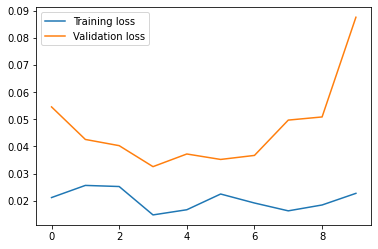

In [327]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

The model appears in this case to be overfitting.

In [334]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.7))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_50 (LSTM)               (None, 7, 64)             22528     
_________________________________________________________________
lstm_51 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 33        
Total params: 34,977
Trainable params: 34,977
Non-trainable params: 0
_________________________________________________________________


In [335]:
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
13/13 [==============================] - 1s 26ms/step - loss: 0.7565 - val_loss: 1.7199
Epoch 2/10
13/13 [==============================] - 0s 8ms/step - loss: 0.4011 - val_loss: 1.4906
Epoch 3/10
13/13 [==============================] - 0s 7ms/step - loss: 0.3471 - val_loss: 1.3762
Epoch 4/10
13/13 [==============================] - 0s 7ms/step - loss: 0.2310 - val_loss: 1.2716
Epoch 5/10
13/13 [==============================] - 0s 6ms/step - loss: 0.2790 - val_loss: 1.0495
Epoch 6/10
13/13 [==============================] - 0s 7ms/step - loss: 0.2148 - val_loss: 0.9833
Epoch 7/10
13/13 [==============================] - 0s 8ms/step - loss: 0.2561 - val_loss: 1.1320
Epoch 8/10
13/13 [==============================] - 0s 7ms/step - loss: 0.2762 - val_loss: 0.9484
Epoch 9/10
13/13 [==============================] - 0s 7ms/step - loss: 0.2047 - val_loss: 0.5723
Epoch 10/10
13/13 [==============================] - 0s 8ms/step - loss: 0.2360 - val_loss: 0.5450


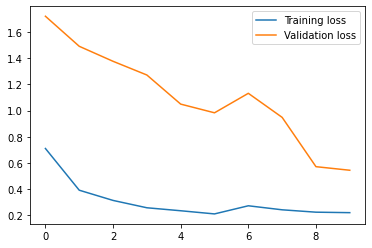

In [336]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

A tunning of the dropout layer of the model helps to reduce the overfitting.

In [337]:
forecast_period_dates = Luxembourg.index[-index_split:]

forecast = model.predict(testX) #forecast 

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, luxembourg.shape[1], axis = -1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,-1]


# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'new_tests_smoothed_per_thousand':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

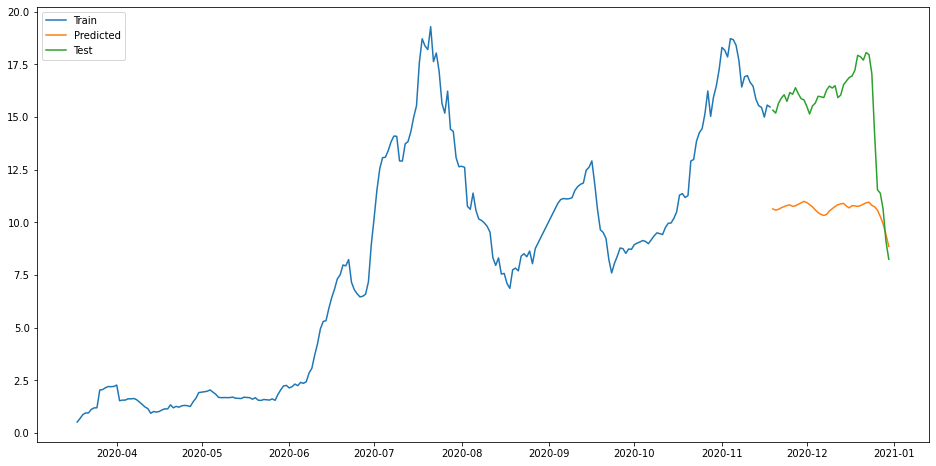

In [338]:
plt.figure(figsize=(16, 8))
plt.plot(Luxembourg.index[:-index_split], Luxembourg['new_tests_smoothed_per_thousand'][:-index_split], label = 'Train')
plt.plot(df_forecast['date'][-index_split:], df_forecast['new_tests_smoothed_per_thousand'][-index_split:], label = 'Predicted')
plt.plot(Luxembourg.index[-index_split:], Luxembourg['new_tests_smoothed_per_thousand'][-index_split:], label = 'Test')
plt.legend()

Once again the constructed model doesn't perform acceptability on the intended dataset for the prediction of the variable 'new_tests_smoothed_per_thousand'.

- **Israel**

In [339]:
Israel = normalize_data[normalize_data['location'] == 'Israel']

Israel = Israel[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
                       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients_per_million', 
                       'hosp_patients_per_million', 'weekly_icu_admissions_per_million', 
                       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand', 
                       'positive_rate', 'tests_per_case', 'stringency_index', 'population_density', 'median_age', 
                       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 
                       'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index',
                       'new_tests_smoothed_per_thousand']]

In [340]:
scaler = StandardScaler()
israel = Israel.values
scaler = scaler.fit(Israel)
df_for_training_scaled = scaler.transform(Israel)

In [341]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to predict into the future
n_past = 7     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:Israel.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, -1])

trainX, trainY = np.array(trainX), np.array(trainY)

index_split = math.ceil(trainX.shape[0]  * .15)

testX = trainX[-index_split:]
testY = trainY[-index_split:]

trainX = trainX[:-index_split]
trainY = trainY[:-index_split]

In [353]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 7, 64)             22528     
_________________________________________________________________
lstm_55 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 33        
Total params: 34,977
Trainable params: 34,977
Non-trainable params: 0
_________________________________________________________________


In [354]:
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
14/14 [==============================] - 2s 27ms/step - loss: 0.3246 - val_loss: 0.0984
Epoch 2/10
14/14 [==============================] - 0s 9ms/step - loss: 0.1364 - val_loss: 0.0612
Epoch 3/10
14/14 [==============================] - 0s 8ms/step - loss: 0.0913 - val_loss: 0.0690
Epoch 4/10
14/14 [==============================] - 0s 10ms/step - loss: 0.0760 - val_loss: 0.0596
Epoch 5/10
14/14 [==============================] - 0s 10ms/step - loss: 0.0878 - val_loss: 0.0523
Epoch 6/10
14/14 [==============================] - 0s 9ms/step - loss: 0.0837 - val_loss: 0.0611
Epoch 7/10
14/14 [==============================] - 0s 10ms/step - loss: 0.0593 - val_loss: 0.0349
Epoch 8/10
14/14 [==============================] - 0s 10ms/step - loss: 0.0639 - val_loss: 0.0252
Epoch 9/10
14/14 [==============================] - 0s 8ms/step - loss: 0.0674 - val_loss: 0.0300
Epoch 10/10
14/14 [==============================] - 0s 9ms/step - loss: 0.0513 - val_loss: 0.0452


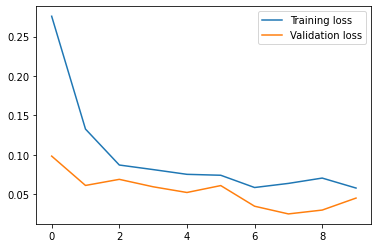

In [355]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

The model appears to have good 'loss' metrics.

In [356]:
forecast_period_dates = Israel.index[-index_split:]

forecast = model.predict(testX) #forecast 

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, Israel.shape[1], axis = -1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,-1]


# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'new_tests_smoothed_per_thousand':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

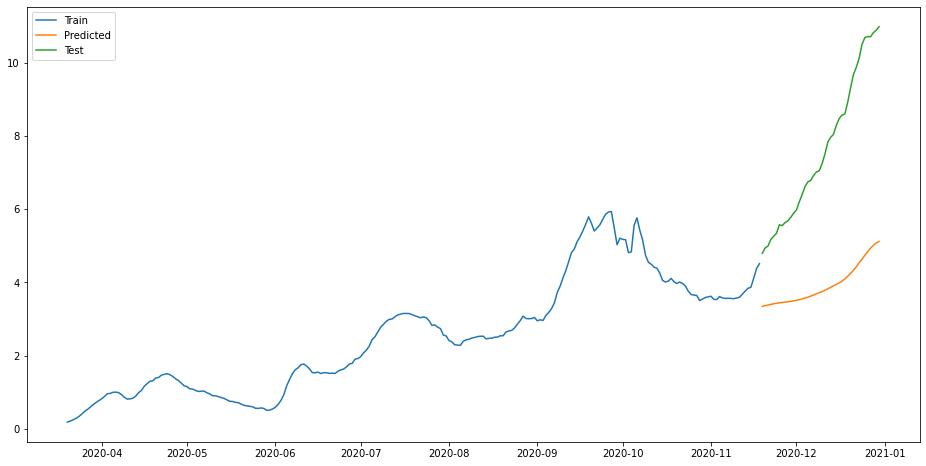

In [357]:
plt.figure(figsize=(16,8))
plt.plot(Israel.index[:-index_split], Israel['new_tests_smoothed_per_thousand'][:-index_split], label = 'Train')
plt.plot(df_forecast['date'][-index_split:], df_forecast['new_tests_smoothed_per_thousand'][-index_split:], label = 'Predicted')
plt.plot(Israel.index[-index_split:], Israel['new_tests_smoothed_per_thousand'][-index_split:], label = 'Test')
plt.legend()

This model as we can observe in the plot above is also unsatisfactory for the prediction of the variable 'new_tests_smoothed_per_thousand' on this dataset.

- **Chile**

In [358]:
Chile = normalize_data[normalize_data['location'] == 'Chile']

Chile = Chile[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
                       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients_per_million', 
                       'hosp_patients_per_million', 'weekly_icu_admissions_per_million', 
                       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand', 
                       'positive_rate', 'tests_per_case', 'stringency_index', 'population_density', 'median_age', 
                       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 
                       'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index',
                       'new_tests_smoothed_per_thousand']]

In [359]:
scaler = StandardScaler()
chile = Chile.values
scaler = scaler.fit(Chile)
df_for_training_scaled = scaler.transform(Chile)

In [360]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to predict into the future
n_past = 7     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:Chile.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, -1])

trainX, trainY = np.array(trainX), np.array(trainY)

index_split = math.ceil(trainX.shape[0]  * .15)

testX = trainX[-index_split:]
testY = trainY[-index_split:]

trainX = trainX[:-index_split]
trainY = trainY[:-index_split]

In [361]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_56 (LSTM)               (None, 7, 64)             22528     
_________________________________________________________________
lstm_57 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_12 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 33        
Total params: 34,977
Trainable params: 34,977
Non-trainable params: 0
_________________________________________________________________


In [362]:
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/10
13/13 [==============================] - 2s 27ms/step - loss: 0.6754 - val_loss: 0.7266
Epoch 2/10
13/13 [==============================] - 0s 9ms/step - loss: 0.2128 - val_loss: 0.0101
Epoch 3/10
13/13 [==============================] - 0s 9ms/step - loss: 0.0745 - val_loss: 0.0019
Epoch 4/10
13/13 [==============================] - 0s 29ms/step - loss: 0.0698 - val_loss: 0.0041
Epoch 5/10
13/13 [==============================] - 0s 9ms/step - loss: 0.0706 - val_loss: 0.0080
Epoch 6/10
13/13 [==============================] - 0s 9ms/step - loss: 0.0506 - val_loss: 0.0139
Epoch 7/10
13/13 [==============================] - 0s 14ms/step - loss: 0.0628 - val_loss: 0.0038
Epoch 8/10
13/13 [==============================] - 0s 9ms/step - loss: 0.0796 - val_loss: 0.0012
Epoch 9/10
13/13 [==============================] - 0s 8ms/step - loss: 0.0441 - val_loss: 0.0080
Epoch 10/10
13/13 [==============================] - 0s 9ms/step - loss: 0.0471 - val_loss: 0.0026


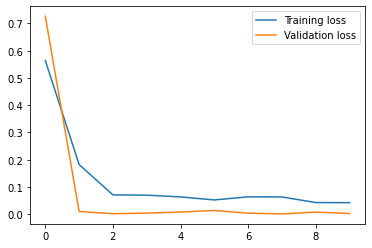

In [363]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

The model shows good performance for the 'loss' metrics.

In [364]:
forecast_period_dates = Chile.index[-index_split:]

forecast = model.predict(testX) #forecast 

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, Israel.shape[1], axis = -1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,-1]


# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'new_tests_smoothed_per_thousand':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

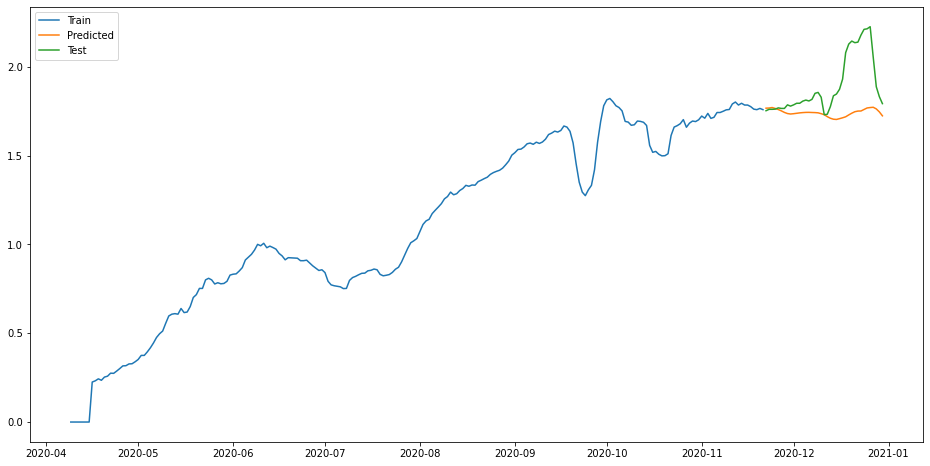

In [365]:
plt.figure(figsize=(16, 8))
plt.plot(Chile.index[:-index_split], Chile['new_tests_smoothed_per_thousand'][:-index_split], label = 'Train')
plt.plot(df_forecast['date'][-index_split:], df_forecast['new_tests_smoothed_per_thousand'][-index_split:], label = 'Predicted')
plt.plot(Chile.index[-index_split:], Chile['new_tests_smoothed_per_thousand'][-index_split:], label = 'Test')
plt.legend()

Despite the previous observations on the 'loss' metrics the model doesn't predict correctly the variable 'new_tests_smoothed_per_thousand' for this dataset.

- **Tunisia**

In [366]:
Tunisia = normalize_data[normalize_data['location'] == 'Tunisia']

Tunisia= Tunisia[['total_cases_per_million', 'new_cases_smoothed_per_million', 'total_deaths_per_million',
                       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients_per_million', 
                       'hosp_patients_per_million', 'weekly_icu_admissions_per_million', 
                       'weekly_hosp_admissions_per_million', 'total_tests_per_thousand', 
                       'positive_rate', 'tests_per_case', 'stringency_index', 'population_density', 'median_age', 
                       'aged_65_older', 'aged_70_older', 'gdp_per_capita', 'extreme_poverty', 
                       'hospital_beds_per_thousand', 'life_expectancy', 'human_development_index',
                       'new_tests_smoothed_per_thousand']]

In [367]:
scaler = StandardScaler()
tunisia = Tunisia.values
scaler = scaler.fit(Tunisia)
df_for_training_scaled = scaler.transform(Tunisia)

In [368]:
trainX = []
trainY = []

n_future = 1   # Number of days we want to predict into the future
n_past = 7     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:Tunisia.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, -1])

trainX, trainY = np.array(trainX), np.array(trainY)

index_split = math.ceil(trainX.shape[0]  * .15)

testX = trainX[-index_split:]
testY = trainY[-index_split:]

trainX = trainX[:-index_split]
trainY = trainY[:-index_split]

In [383]:

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, 7, 64)             22528     
_________________________________________________________________
lstm_63 (LSTM)               (None, 32)                12416     
_________________________________________________________________
dropout_15 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 33        
Total params: 34,977
Trainable params: 34,977
Non-trainable params: 0
_________________________________________________________________


In [384]:
history = model.fit(trainX, trainY, epochs=20, batch_size=16, validation_split=0.1, verbose=1)

Epoch 1/20
8/8 [==============================] - 2s 43ms/step - loss: 0.2601 - val_loss: 0.5624
Epoch 2/20
8/8 [==============================] - 0s 12ms/step - loss: 0.1583 - val_loss: 0.6226
Epoch 3/20
8/8 [==============================] - 0s 10ms/step - loss: 0.1253 - val_loss: 0.4595
Epoch 4/20
8/8 [==============================] - 0s 10ms/step - loss: 0.1072 - val_loss: 0.4323
Epoch 5/20
8/8 [==============================] - 0s 10ms/step - loss: 0.0858 - val_loss: 0.4192
Epoch 6/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0688 - val_loss: 0.2952
Epoch 7/20
8/8 [==============================] - 0s 12ms/step - loss: 0.1162 - val_loss: 0.3004
Epoch 8/20
8/8 [==============================] - 0s 9ms/step - loss: 0.0750 - val_loss: 0.2876
Epoch 9/20
8/8 [==============================] - 0s 11ms/step - loss: 0.0790 - val_loss: 0.2653
Epoch 10/20
8/8 [==============================] - 0s 12ms/step - loss: 0.1033 - val_loss: 0.2773
Epoch 11/20
8/8 [=============

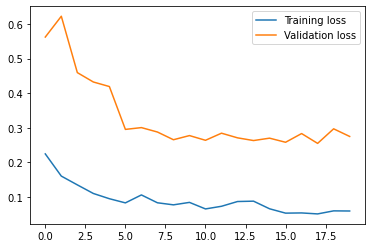

In [385]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

Despite all the attempts to reduce the overfitting, the model still presents this tendency.

In [386]:
forecast_period_dates = Tunisia.index[-index_split:]

forecast = model.predict(testX) #forecast 

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
forecast_copies = np.repeat(forecast, Israel.shape[1], axis = -1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,-1]


# Convert timestamp to date
forecast_dates = []
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'date':np.array(forecast_dates), 'new_tests_smoothed_per_thousand':y_pred_future})
df_forecast['date']=pd.to_datetime(df_forecast['date'])

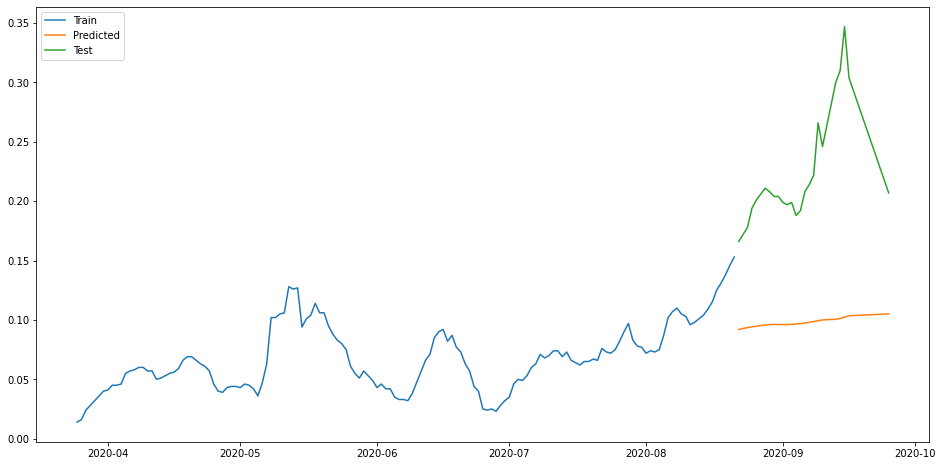

In [387]:
plt.figure(figsize=(16, 8))
plt.plot(Tunisia.index[:-index_split], Tunisia['new_tests_smoothed_per_thousand'][:-index_split], label = 'Train')
plt.plot(df_forecast['date'][-index_split:], df_forecast['new_tests_smoothed_per_thousand'][-index_split:], label = 'Predicted')
plt.plot(Tunisia.index[-index_split:], Tunisia['new_tests_smoothed_per_thousand'][-index_split:], label = 'Test')
plt.legend()

The model can't predict the variable 'new_tests_smoothed_per_thousand', possibly due to an overfitting event.

## Conclusions

Our goal for this project was to determine what influences the variation of the number of tests performed worldwide.
We also wanted to predict future values for the variable chosen to represent the number of tests performed.

Since we are working with a time series and to perform the ML analysis, we need it to be stationary, we performed a detrending procedure on the dataset.

After screening the dataset, we chose the variable 'new_tests_smoothed_per_thousand'. Before focusing on this variable we wanted to know what variables influenced the variation in the dataset. We then performed a PCA on both the dataset detrended and the original. The variable 'gdp_per_capita' was the most influential, appearing on both analyses. 

We separated the datasets (original and detrended) by country, because each country has its own set of timeseries with some variables having some extremely uneven values between countries.

After that, we constructed the ML models for the detrended dataset. We wanted to build models able to predict the variable 'new_tests_smoothed_per_thousand'. Because we are working with a time series we want to give the data for the variable on the instance (t-n) to predict the instance on (t) and for that reason we constructed the models with a sliding window method.
We applied that sliding window method and used 3 different architectures, but none of the models performed well for the selected datasets (countries with the highest 'gdp_per_capita' in each continent). We also applied an ARIMA model for the time series of the same countries as before, however the results were also unsatisfactory. It was noticeable that the number of entries was very low for all the countries (less than a year of daily data), and that is probably the major issue with our models.

After the ML models we tried to apply DL models. On the DL models we performed the sliding window method for them all, differing the approach on the variables to give to the model - univariate and multivariate. The better results appeared when we used only past values of 'new_tests_smoothed_per_thousand' for the training of the models (like you could do to predict a stock price variation), this approach allowed as well to predict the next value of 'new_tests_smoothed_per_thousand' (value for the day after all the entries registered). The analysis with multiple variables performed poorly in all countries. 

Since this pandemic affected countries at different days, some countries have more data entries than others and the models also vary their performance on the different datasets. It was observable a tendency to overfit on some countries, which could be also related to the lack of data. We conclude that a greater number of entries could help a better assessment of the data and would allow for better predictions (these approaches showed better performances on datasets containing more years worth of entries).

## References

    [1]  Hasell, J., Mathieu, E., Beltekian, D. et al. A cross-country database of COVID-19 testing. Sci Data 7, 345 (2020)
    [2]  Hannah Ritchie (2019) - "Age Structure". Published online at OurWorldInData.org. Retrieved from: 'https://ourworldindata.org/age-structure' [Online Resource]
    [3] UN. (2017). Changing population age structures and sustainable development. Department of Economic and Social Affairs, ST/ESA/SER(E/CN.9/2017/2), 33.
    [4] https://towardsdatascience.com/time-series-analysis-using-pandas-in-python-f726d87a97d8
    [5] https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1